# $\color{blue}{\text{C5.0(fullDT) implementation and evaluation:}}$

This document takes 22 minutes to run

## $\color{purple}{\text{Pre-work functions:}}$

### $\color{green}{\text{Global Environment 'constant' objects:}}$

In [1]:
# Function taken from lab 4
rm(list=ls())
# Define the libraries used in this project

# Library from CRAN     Version
# pacman	               0.5.1
# outliers	             0.14
# corrplot	             0.84
# MASS	                 7.3.53
# formattable 	         0.2.0.1
# stats                  4.0.3
# PerformanceAnalytics   2.0.4
# stringr                1.4.0
# partykit               1.2.8
# C50                    0.1.3.1
# randomForest           4.6.14
# h2o                    3.32.0.4
# keras                  2.3.0.0

MYLIBRARIES<-c("outliers",
               "corrplot",
               "formattable",
               "stats",
               "caret",
               "PerformanceAnalytics",
               "stringr",
               "partykit",
               "C50",
               "randomForest",
               #"keras",
               "h2o")

KFOLDS          <- 6                 # Number of folded experiments

# User defined functions are next


### $\color{green}{\text{R starts execution:}}$

In [2]:
# Function taken from lab 4
# This is where R starts execution
# h20 error first time, re-run section and it installed fine

gc() # garbage collection to automatically release memory

# clear plots and other graphics
if(!is.null(dev.list())) dev.off()
graphics.off()

# This clears all warning messages
#assign("last.warning", NULL, envir = baseenv())

# clears the console area
cat("\014")

print("START Supervised Machine Learning")

library(pacman)
pacman::p_load(char=MYLIBRARIES,install=TRUE,character.only=TRUE)


set.seed(123)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,617252,33.0,1338437,71.5,1338437,71.5
Vcells,1143308,8.8,8388608,64.0,1819987,13.9


null device 
          1

[1] "START Supervised Machine Learning"


## $\color{purple}{\text{Loading, class balancing and splitting the data:}}$

In this first step the data was reduced to 10% of its original volume (named 'brfssCleanedSmall'), to allow faster testing of the hyperparameter values:

In [3]:
newDataset <- read.csv(file = 'brfssCleanedSmall.csv')
# newDataset <- read.csv(file = 'brfssCleaned.csv')
head(newDataset)

,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,EXERANY2,SLEPTIM1,⋯,ECIGARET,QSTVER,QSTLANG,METSTAT,URBSTAT,PRACE1,AGEG5YR,HTM4,BMI5,DROCDY3_
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,⋯,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0.50,0.0,0.00000000,0,0,1,0.25,0,0.2608696,⋯,1,0.7692308,0,1,0,0.1428571,0.75000000,0.6133333,0.3552830,0.00
2,0,0.25,0.0,0.06666667,0,1,0,0.25,0,0.2608696,⋯,1,0.7692308,0,0,0,0.0000000,0.50000000,0.6266667,0.1510242,0.57
3,0,0.25,0.1,0.00000000,0,0,1,0.25,0,0.2173913,⋯,1,0.9230769,0,0,0,0.0000000,0.66666667,0.5133333,0.1884772,0.13
4,0,0.00,0.0,0.00000000,0,0,1,0.25,0,0.2608696,⋯,1,0.7692308,0,1,0,0.0000000,0.75000000,0.5600000,0.1429233,0.50
5,0,0.25,0.0,0.00000000,0,1,1,0.50,0,0.2173913,⋯,1,0.7692308,0,0,0,0.0000000,0.08333333,0.5466667,0.1512556,0.07
6,0,0.00,0.0,0.00000000,0,0,1,0.25,0,0.2608696,⋯,1,0.7692308,0,1,0,0.0000000,0.58333333,0.5800000,0.1514871,0.14


Below we are setting the target diseases as factors in the dataset:

In [4]:
newDataset$ASTHMA3 <- as.factor(newDataset$ASTHMA3) # Asthma
newDataset$CVDCRHD4 <- as.factor(newDataset$CVDCRHD4) # Cardiovascular Disease
newDataset$CHCSCNCR <- as.factor(newDataset$CHCSCNCR) # Skin Cancer
newDataset$CHCKDNY2 <- as.factor(newDataset$CHCKDNY2) # Kidney Disease 
newDataset$HAVARTH4 <- as.factor(newDataset$HAVARTH4) # Arthritis
newDataset$CHCOCNCR <- as.factor(newDataset$CHCOCNCR) # Skin Cancer
newDataset$CHCCOPD2 <- as.factor(newDataset$CHCCOPD2) # Pulmonary Disease
newDataset$DIABETE4 <- as.factor(newDataset$DIABETE4) # Diabetes

### $\color{green}{\text{Loading R libraries:}}$

In [5]:
# install packages below if necessary

# install.packages('C50', dependencies = T)
# install.packages("pacman")
# install.packages("ROSE")
# install.packages("randomForest")
# install.packages('e1071', dependencies=TRUE)
# install.packages('caret', dependencies=TRUE)
library(ROSE)
library(randomForest)
library(caret)
library(e1071)
# load the library
library("ggplot2")

Loaded ROSE 0.0-4



Attaching package: ‘e1071’


The following objects are masked from ‘package:PerformanceAnalytics’:

    kurtosis, skewness




### Train and test data split:

In [6]:
# Creating a smaller subset on the data to test hyperparameters as code will take too long with full dataset
set.seed(100) # setting the same seed for reproducability
ind <- sample(nrow(newDataset), 0.7*nrow(newDataset), replace = FALSE)
# Splitting data into testing and training
train <- newDataset[ind,]
test <- newDataset[-ind,]

In [7]:
# creating balanced undersamples of the training data to train fullDT() (C50) on
undersampleASTH <- ovun.sample(ASTHMA3~., data = train, method = "under", p = 0.5)$data
undersampleHEART <- ovun.sample(CVDCRHD4~., data = train, method = "under", p = 0.5)$data
undersampleSKIN <- ovun.sample(CHCSCNCR~., data = train, method = "under", p = 0.5)$data
undersampleKIDNEY <- ovun.sample(CHCKDNY2~., data = train, method = "under", p = 0.5)$data
undersampleARTH <- ovun.sample(HAVARTH4~., data = train, method = "under", p = 0.5)$data
undersampleCANCER <- ovun.sample(CHCOCNCR~., data = train, method = "under", p = 0.5)$data
undersampleLUNG <- ovun.sample(CHCCOPD2~., data = train, method = "under", p = 0.5)$data
undersampleDIAB <- ovun.sample(DIABETE4~., data = train, method = "under", p = 0.5)$data

In [8]:
# ncol(train)
head(undersampleASTH)

,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,EXERANY2,SLEPTIM1,⋯,ECIGARET,QSTVER,QSTLANG,METSTAT,URBSTAT,PRACE1,AGEG5YR,HTM4,BMI5,DROCDY3_
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,⋯,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0.50,0.0000000,0.0,0,0,1,0.25,0,0.2608696,⋯,1,0.8461538,0,0,0,0.0000000,0.1666667,0.5600000,0.1684990,0.00
2,1,0.25,0.0000000,0.0,0,1,1,0.25,1,0.3043478,⋯,1,0.7692308,0,1,0,0.0000000,0.5833333,0.4800000,0.1884772,1.00
3,0,0.75,0.4666667,0.0,0,1,1,0.25,0,0.1304348,⋯,1,0.7692308,0,0,0,0.2857143,0.2500000,0.4800000,0.2382826,0.00
4,0,0.00,0.0000000,0.0,0,0,1,0.25,0,0.2608696,⋯,1,0.7692308,0,1,1,0.0000000,0.6666667,0.5933333,0.1513714,0.00
5,1,0.50,0.1666667,0.1,0,0,1,0.25,1,0.2608696,⋯,1,0.0000000,0,0,0,0.0000000,0.4166667,0.4800000,0.2581877,0.17
6,0,0.25,0.0000000,0.0,0,0,1,0.25,0,0.3043478,⋯,1,0.0000000,0,1,1,0.0000000,0.9166667,0.5466667,0.1952320,1.00


### NcalcConfusion() function:

Calculate a confusion matrix for 2-class classifier

Converts values to doubles to avoid integers overflowing

Updated to the following definition of the confusion matrix

A good loan is indicated when \\$Status=1 and bad when \\$Status=0

In [9]:
# Function taken from lab 4

# INPUT: vector - expectedClass  - {0,1}, Expected outcome from each row (labels)
#        vector - predictedClass - {0,1}, Predicted outcome from each row (labels)
#
# OUTPUT: A list with the  entries from NcalcMeasures()

NcalcConfusion<-function(expectedClass,predictedClass){
    # Factors are the data objects which are used to categorize the data and store it
    # as levels. They can store both strings and integers. They are useful in the columns
    # which have a limited number of unique values. Like "Male, "Female" and True, False etc
    confusion<-table(factor(predictedClass,levels=0:1),factor(expectedClass,levels=0:1))
    # This "converts" the above into our preferred format

    TP<-as.double(confusion[2,2])
    FN<-as.double(confusion[1,2])
    FP<-as.double(confusion[2,1])
    TN<-as.double(confusion[1,1])

    return(NcalcMeasures(TP,FN,FP,TN))

} #endof NcalcConfusion()

### NEvaluateClassifier() function:

Use dataset to generate predictions from model

Evaluate as classifier using threshold value

In [10]:
# Function taken from lab 4

# INPUT   :   vector double     - probs        - probability of being class 1
#             Data Frame        - testing_data - Dataset to evaluate
#             double            - threshold     -cutoff (probability) for classification
#
# OUTPUT  :   List       - Named evaluation measures
#                        - Predicted class probability
#
# ************************************************
NEvaluateClassifier<-function(test_predicted,test_expected,threshold) {
    # ifelse() function which takes the vector test_predicted as an input.
    # A logical operation is then performed on test_predicted to determine
    # if the element of test_predicted is smaller than the threshold allocating
    # the value to 0 or larger than the threshold allocating the value to 1
    predictedClass<-ifelse(test_predicted<threshold,0,1)

    results<-NcalcConfusion(expectedClass=test_expected,
                          predictedClass=predictedClass)

    return(results)
} #endof NEvaluateClassifier()

### NcalcMeasures() function:

Evaluation measures for a confusion matrix

We modified it  from lab 4 to add metrics threatScore and balancedacc:

In [11]:
# INPUT: numeric  - TP, FN, FP, TN
#
# OUTPUT: A list with the following entries:
#        TP        - double - True Positive records
#        FP        - double - False Positive records
#        TN        - double - True Negative records
#        FN        - double - False Negative records
#        accuracy  - double - accuracy measure
#        pgood     - double - precision for "good" (values are 1) measure
#        pbad      - double - precision for "bad" (values are 1) measure
#        FPR       - double - FPR measure
#        TPR       - double - FPR measure
#        TNR       - double - TNR measureData Science NHS placement student contact details
#
# added TNR measure
# rounded to sensible number of digits
# ************************************************

NcalcMeasures <- function(TP,FN,FP,TN){
  npv    <-round(100.0*(TN/(FN+TN)),digits=2) ##
  fpr     <-round(100.0*(FP/(FP+TN)),digits=2)
  tpr     <-round(100.0*(TP/(TP+FN)),digits=2) # recall, sensitivity
  tnr     <-round(100.0*(TN/(FP+TN)),digits=2) #specificity
  fnr     <-round(100.0*(FN/(FN+TP)),digits=2) ##
  threatScore    <-round(100.0*(TP/(TP+FN+FP)),digits=2) ##
  balancedacc    <-round(((tpr+tnr)/2),digits=2)
    
    retList<-list("TP"=TP,
                  "FN"=FN,
                  "TN"=TN,
                  "FP"=FP,
                  "NPV"=npv,
                  "FPR"=fpr,
                  "TPR"=tpr,
                  "TNR"=tnr,
                  "FNR"=fnr,
                  "threatScore"=threatScore,
                  "balancedacc"=balancedacc
    )
    return(retList)
}

### C5.0(fullDT()) function:

I modified it from lab 4 to only yield metrics in NCalcMeasures and not plot anything to increase the variety of the plots I can create 

In [12]:
# Function taken from lab 4
fullDT<-function(train,test,outputfield="",boost=1,plot=TRUE){
    
    allResults<-data.frame()

    # Takes the position of the label based on what is specified in outputfield
    
    positionClassOutput<-which(names(train)==outputfield)

    # train data: dataframe with the input fields
    train_inputs<-train[-positionClassOutput]
    
    # test data: dataframe with with just input fields
    test_inputs<-test[-positionClassOutput]

    # train data: vector with the expected output
    train_expected<-train[,positionClassOutput]

    #test data: vector with just the expected output class
    test_expected<-test[,positionClassOutput]

    # ************************************************
    # Create a standard Decision Tree using the C5.0 algorithm
    # Uses library C50
    # Outputs the tree in the format of rules


    tree<-C50::C5.0(x=train_inputs,
                  factor(train_expected),
                  rules=TRUE,
                  trials=boost)
    
    # Generate class membership probabilities

    testPredictedClassProbs<-predict(tree,test_inputs, type="prob")

    # Use the created decision tree with the test dataset
    # to determine best classification threshold & calculate metrics

    for(threshold in seq(0.01,1,by=0.01)){
        results<-NEvaluateClassifier(test_predicted=testPredictedClassProbs[,2],
                                  test_expected=test_expected,
                                  threshold=threshold)
        allResults<-rbind(allResults,data.frame(x=threshold,npv=results$NPV,fpr=results$FPR,tpr=results$TPR,tnr=results$TNR,fnr=results$FNR,threatScore=results$threatScore,balancedacc=results$balancedacc))
    }

  return(allResults)
} #endof fullDT()




## $\color{purple}{\text{Hyperparameter tuning:}}$

For each of the target diseases the C5.0 model was executed for a range of 1 to 20 with increments of 1 to determine the amount of trials/boosting that yields the best balanced accuracy

## ASTHMA

In [13]:
diseaseName<-"ASTHMA3"
dfbalaccur<-data.frame() # initiating the dataframe where the results for the plot will be stored
for(bst in seq(1,20,by=1)){
    ASTH <- fullDT(undersampleASTH,test,outputfield=diseaseName,boost=bst,plot=TRUE) # trains alsgorithm for boost number "bst"
    ASTH$distance<-sqrt(((100-ASTH$tpr)^2)+((ASTH$fpr)^2)) # calculates the Euclidean distance
    # calculates the min Euclidean distance to find the balanced accuracy at the ideal threshold for each boost number
    balacc<-ASTH$balancedacc[which.min(ASTH$distance)] 
    dfbalaccur<-rbind(dfbalaccur,data.frame(boostn=bst,balaccur=balacc)) # concatenates the results of boost number and balanced accuracies
}

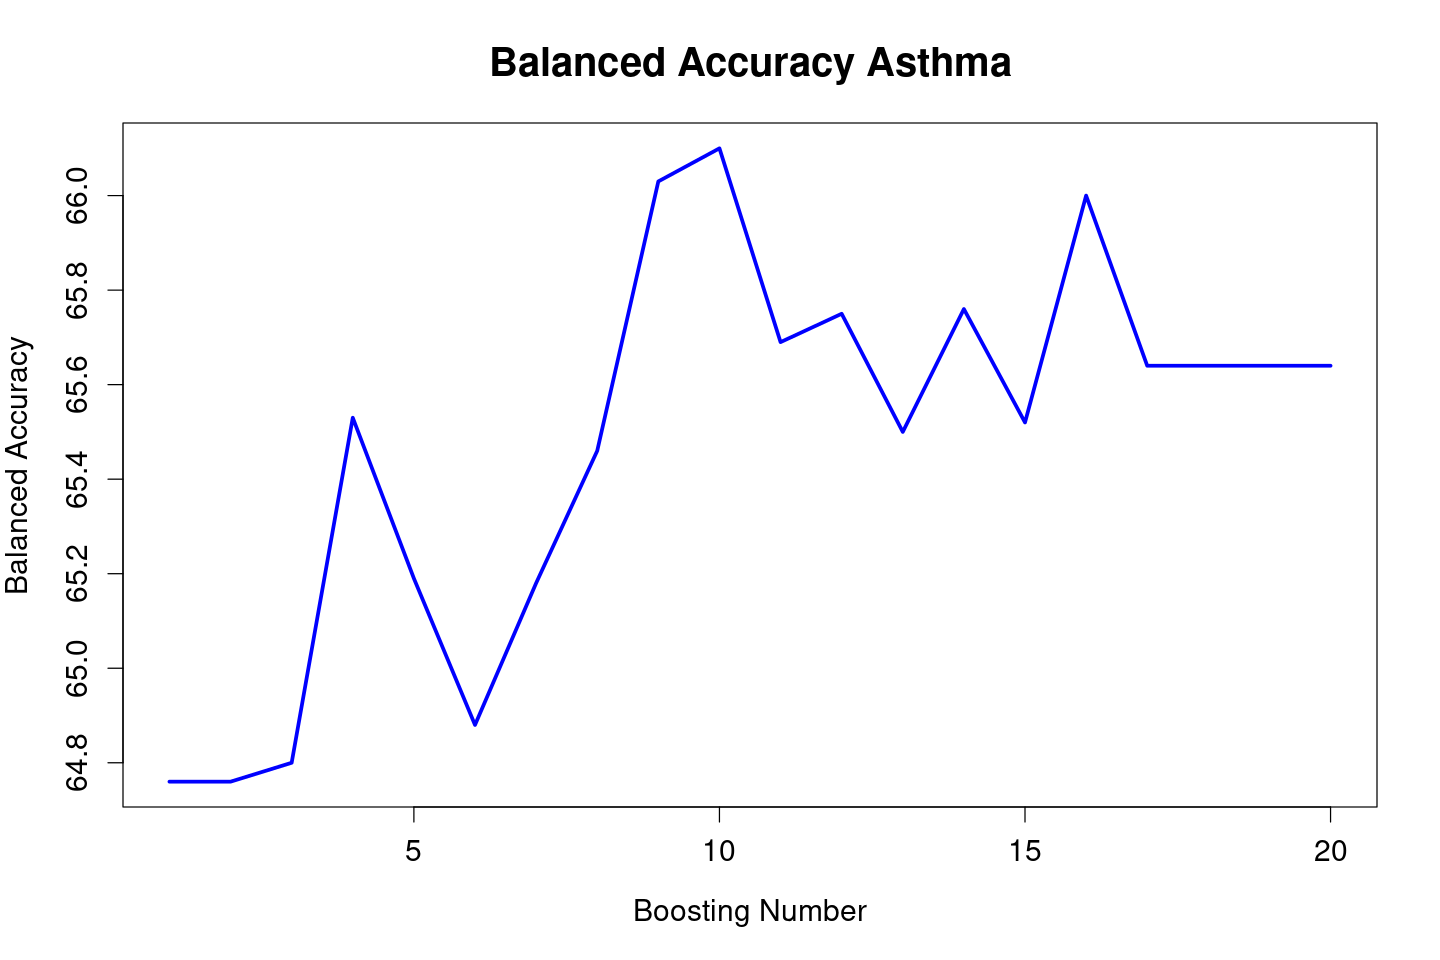

In [14]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
plot(dfbalaccur$boostn,dfbalaccur$balaccur,
#      xlim=c(0, 20), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Boosting Number",
     ylab="Balanced Accuracy",
     main=paste("Balanced Accuracy Asthma"),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

For each different disease the maximum balanced accuracy was calculated, along with its corresponding boost number and the results were stored in dataframe "dfmaxacc"

In [15]:
dfmaxacc<-data.frame()
maxacboost<-dfbalaccur$boostn[which.max(dfbalaccur$balaccur)] # calculates the boost number corresponding to the max balanced accuracy
maxaccu<-dfbalaccur$balaccur[which.max(dfbalaccur$balaccur)] # calculates the max balanced accuracy in the boosting number range 1 -20
print(paste("The best balanced accuracy is obtained at boost =",maxacboost))
dfmaxacc<-rbind(dfmaxacc,data.frame(boostnmbr=maxacboost,balancedAccur=maxaccu, disease=diseaseName))

[1] "The best balanced accuracy is obtained at boost = 10"


## HEART DISEASE

In [16]:
diseaseName<-"CVDCRHD4"
dfbalaccur<-data.frame()
for(bst in seq(1,20,by=1)){
    HEART <- fullDT(undersampleHEART,test,outputfield=diseaseName,boost=bst,plot=TRUE)
    HEART$distance<-sqrt(((100-HEART$tpr)^2)+((HEART$fpr)^2))
    balacc<-HEART$balancedacc[which.min(HEART$distance)]
    dfbalaccur<-rbind(dfbalaccur,data.frame(boostn=bst,balaccur=balacc))
}

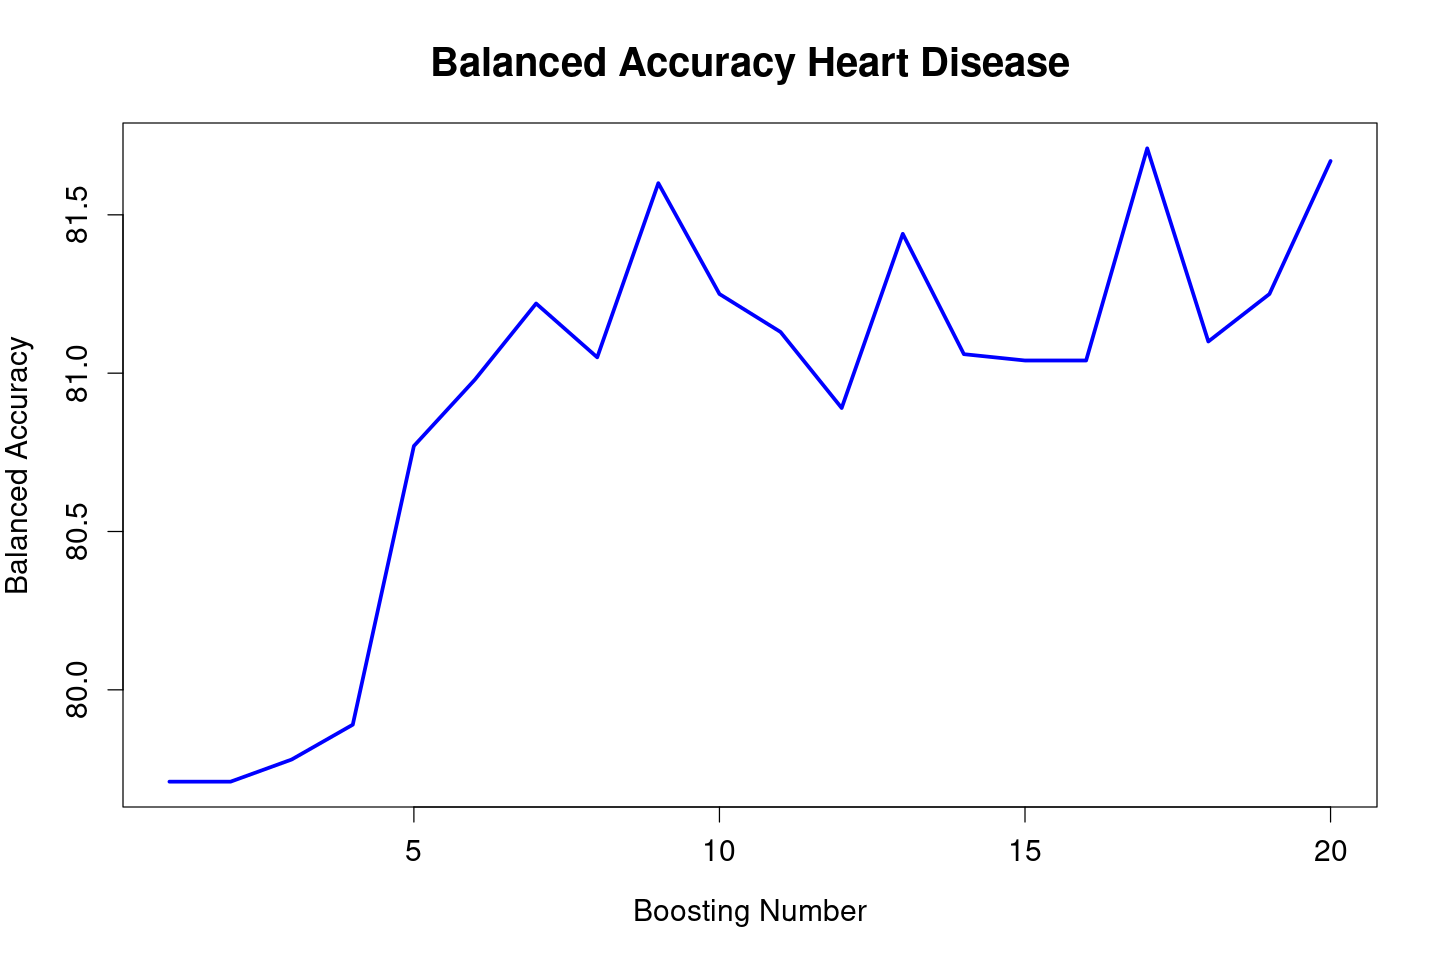

In [17]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
plot(dfbalaccur$boostn,dfbalaccur$balaccur,
#      xlim=c(0, 20), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Boosting Number",
     ylab="Balanced Accuracy",
     main=paste("Balanced Accuracy Heart Disease"),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

In [18]:
maxacboost<-dfbalaccur$boostn[which.max(dfbalaccur$balaccur)]
maxaccu<-dfbalaccur$balaccur[which.max(dfbalaccur$balaccur)]
print(paste("The best balanced accuracy is obtained at boost =",maxacboost))
dfmaxacc<-rbind(dfmaxacc,data.frame(boostnmbr=maxacboost,balancedAccur=maxaccu, disease=diseaseName))

[1] "The best balanced accuracy is obtained at boost = 17"


## SKIN CANCER

In [19]:
diseaseName<-"CHCSCNCR"
dfbalaccur<-data.frame()
for(bst in seq(1,20,by=1)){
    SKIN <- fullDT(undersampleSKIN,test,outputfield=diseaseName,boost=bst,plot=TRUE)
    SKIN$distance<-sqrt(((100-SKIN$tpr)^2)+((SKIN$fpr)^2))
    balacc<-SKIN$balancedacc[which.min(SKIN$distance)]
    dfbalaccur<-rbind(dfbalaccur,data.frame(boostn=bst,balaccur=balacc))
}

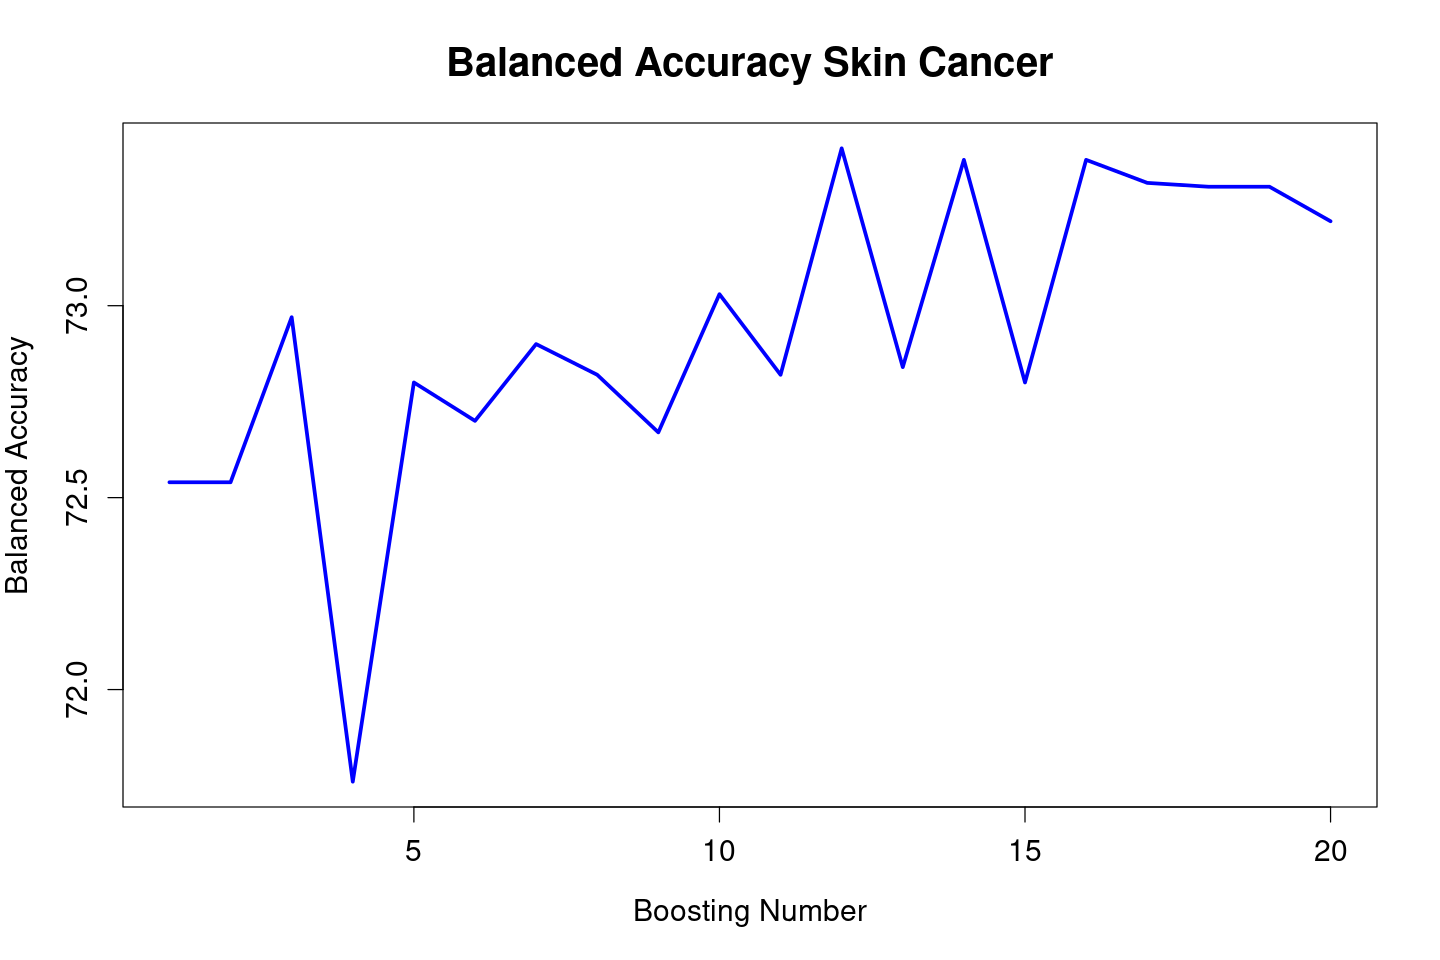

In [20]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
plot(dfbalaccur$boostn,dfbalaccur$balaccur,
#      xlim=c(0, 20), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Boosting Number",
     ylab="Balanced Accuracy",
     main=paste("Balanced Accuracy Skin Cancer"),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

In [21]:
maxacboost<-dfbalaccur$boostn[which.max(dfbalaccur$balaccur)]
maxaccu<-dfbalaccur$balaccur[which.max(dfbalaccur$balaccur)]
print(paste("The best balanced accuracy is obtained at boost =",maxacboost))
dfmaxacc<-rbind(dfmaxacc,data.frame(boostnmbr=maxacboost,balancedAccur=maxaccu, disease=diseaseName))

[1] "The best balanced accuracy is obtained at boost = 12"


## KIDNEY DISEASE

In [22]:
diseaseName<-"CHCKDNY2"
dfbalaccur<-data.frame()
for(bst in seq(1,20,by=1)){
    KIDNEY <- fullDT(undersampleKIDNEY,test,outputfield=diseaseName,boost=bst,plot=TRUE)
    KIDNEY$distance<-sqrt(((100-KIDNEY$tpr)^2)+((KIDNEY$fpr)^2))
    balacc<-KIDNEY$balancedacc[which.min(KIDNEY$distance)]
    dfbalaccur<-rbind(dfbalaccur,data.frame(boostn=bst,balaccur=balacc))
}

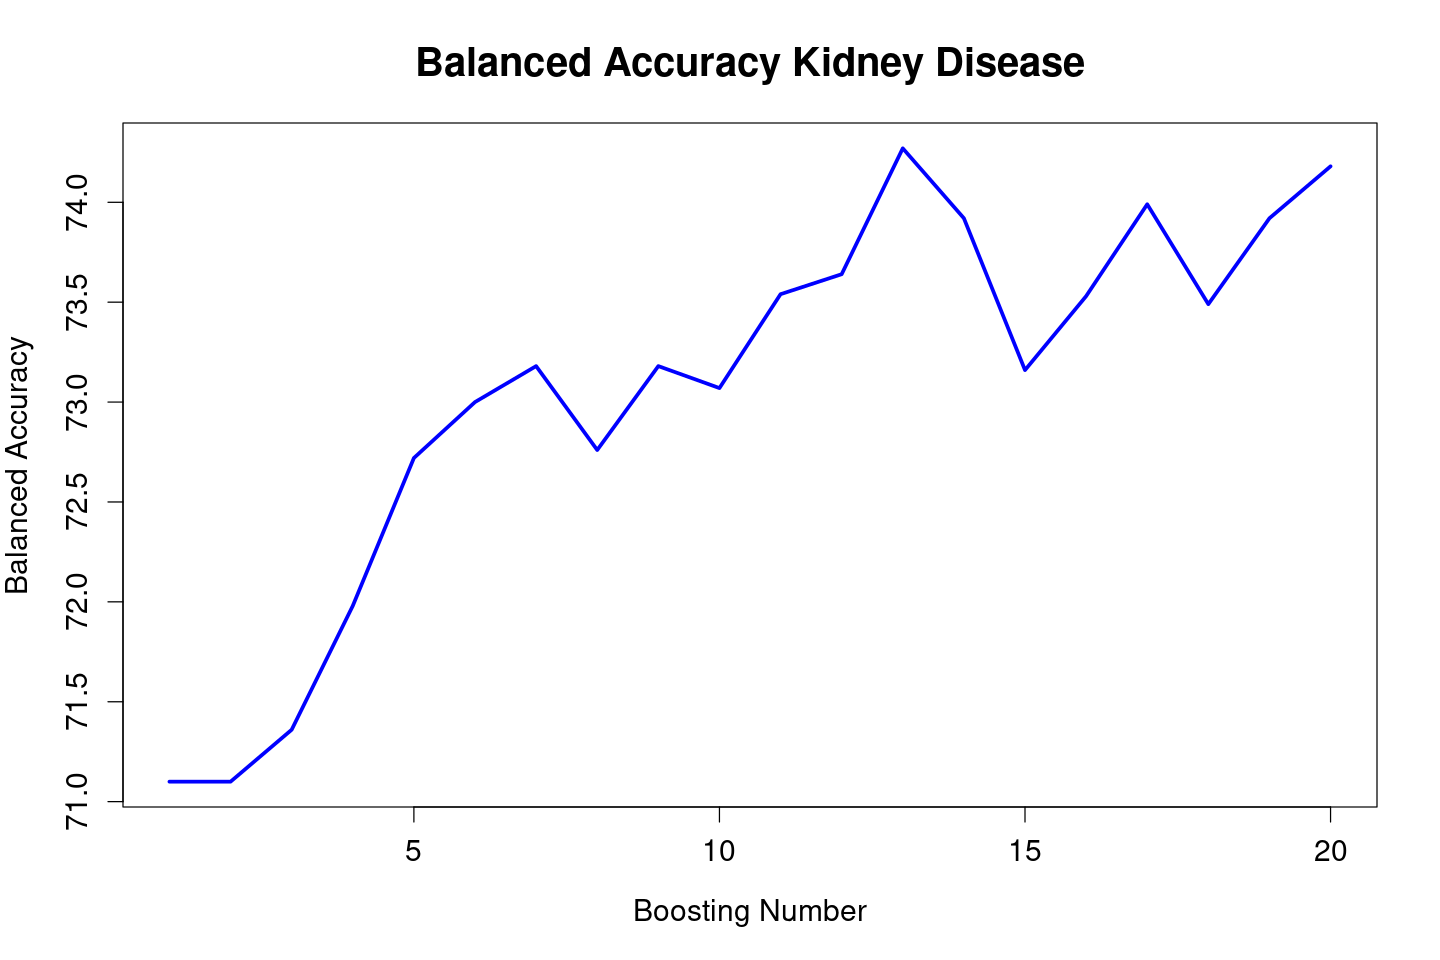

In [23]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
plot(dfbalaccur$boostn,dfbalaccur$balaccur,
#      xlim=c(0, 20), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Boosting Number",
     ylab="Balanced Accuracy",
     main=paste("Balanced Accuracy Kidney Disease"),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

In [24]:
maxacboost<-dfbalaccur$boostn[which.max(dfbalaccur$balaccur)]
maxaccu<-dfbalaccur$balaccur[which.max(dfbalaccur$balaccur)]
print(paste("The best balanced accuracy is obtained at boost =",maxacboost))
dfmaxacc<-rbind(dfmaxacc,data.frame(boostnmbr=maxacboost,balancedAccur=maxaccu, disease=diseaseName))

[1] "The best balanced accuracy is obtained at boost = 13"


## ARTHRITIS

In [25]:
diseaseName<-"HAVARTH4"
dfbalaccur<-data.frame()
for(bst in seq(1,20,by=1)){
    ARTH <- fullDT(undersampleARTH,test,outputfield=diseaseName,boost=bst,plot=TRUE)
    ARTH$distance<-sqrt(((100-ARTH$tpr)^2)+((ARTH$fpr)^2))
    balacc<-ARTH$balancedacc[which.min(ARTH$distance)]
    dfbalaccur<-rbind(dfbalaccur,data.frame(boostn=bst,balaccur=balacc))
}

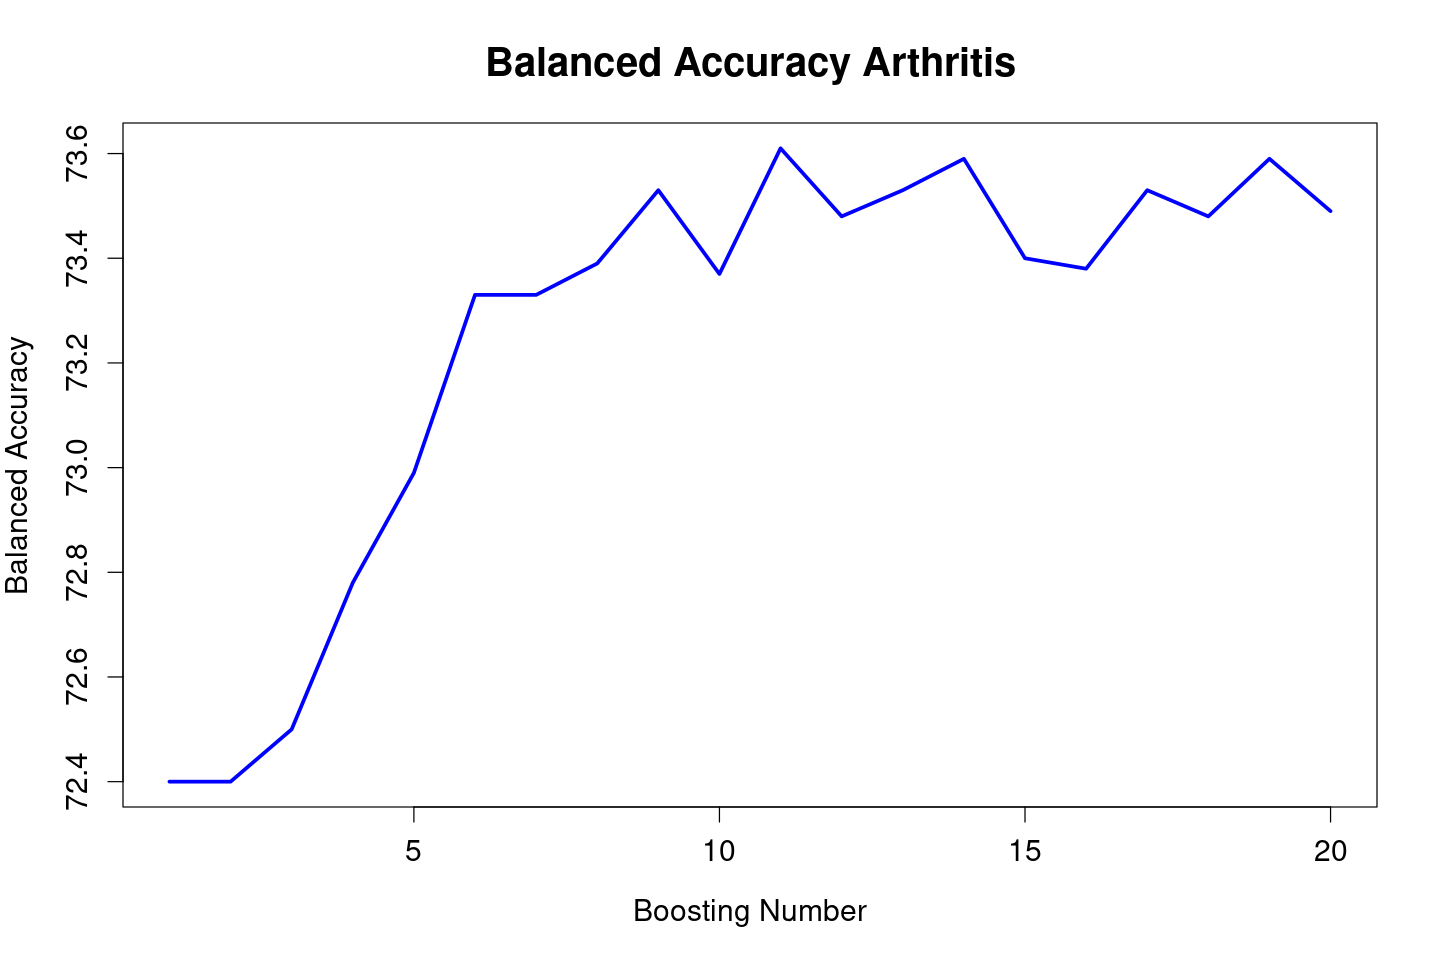

In [26]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
plot(dfbalaccur$boostn,dfbalaccur$balaccur,
#      xlim=c(0, 20), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Boosting Number",
     ylab="Balanced Accuracy",
     main=paste("Balanced Accuracy Arthritis"),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

In [27]:
maxacboost<-dfbalaccur$boostn[which.max(dfbalaccur$balaccur)]
maxaccu<-dfbalaccur$balaccur[which.max(dfbalaccur$balaccur)]
print(paste("The best balanced accuracy is obtained at boost =",maxacboost))
dfmaxacc<-rbind(dfmaxacc,data.frame(boostnmbr=maxacboost,balancedAccur=maxaccu, disease=diseaseName))

[1] "The best balanced accuracy is obtained at boost = 11"


## CANCER

In [28]:
diseaseName<-"CHCOCNCR"
dfbalaccur<-data.frame()
for(bst in seq(1,20,by=1)){
    CANCER <- fullDT(undersampleCANCER,test,outputfield=diseaseName,boost=bst,plot=TRUE)
    CANCER$distance<-sqrt(((100-CANCER$tpr)^2)+((CANCER$fpr)^2))
    balacc<-CANCER$balancedacc[which.min(CANCER$distance)]
    dfbalaccur<-rbind(dfbalaccur,data.frame(boostn=bst,balaccur=balacc))
}

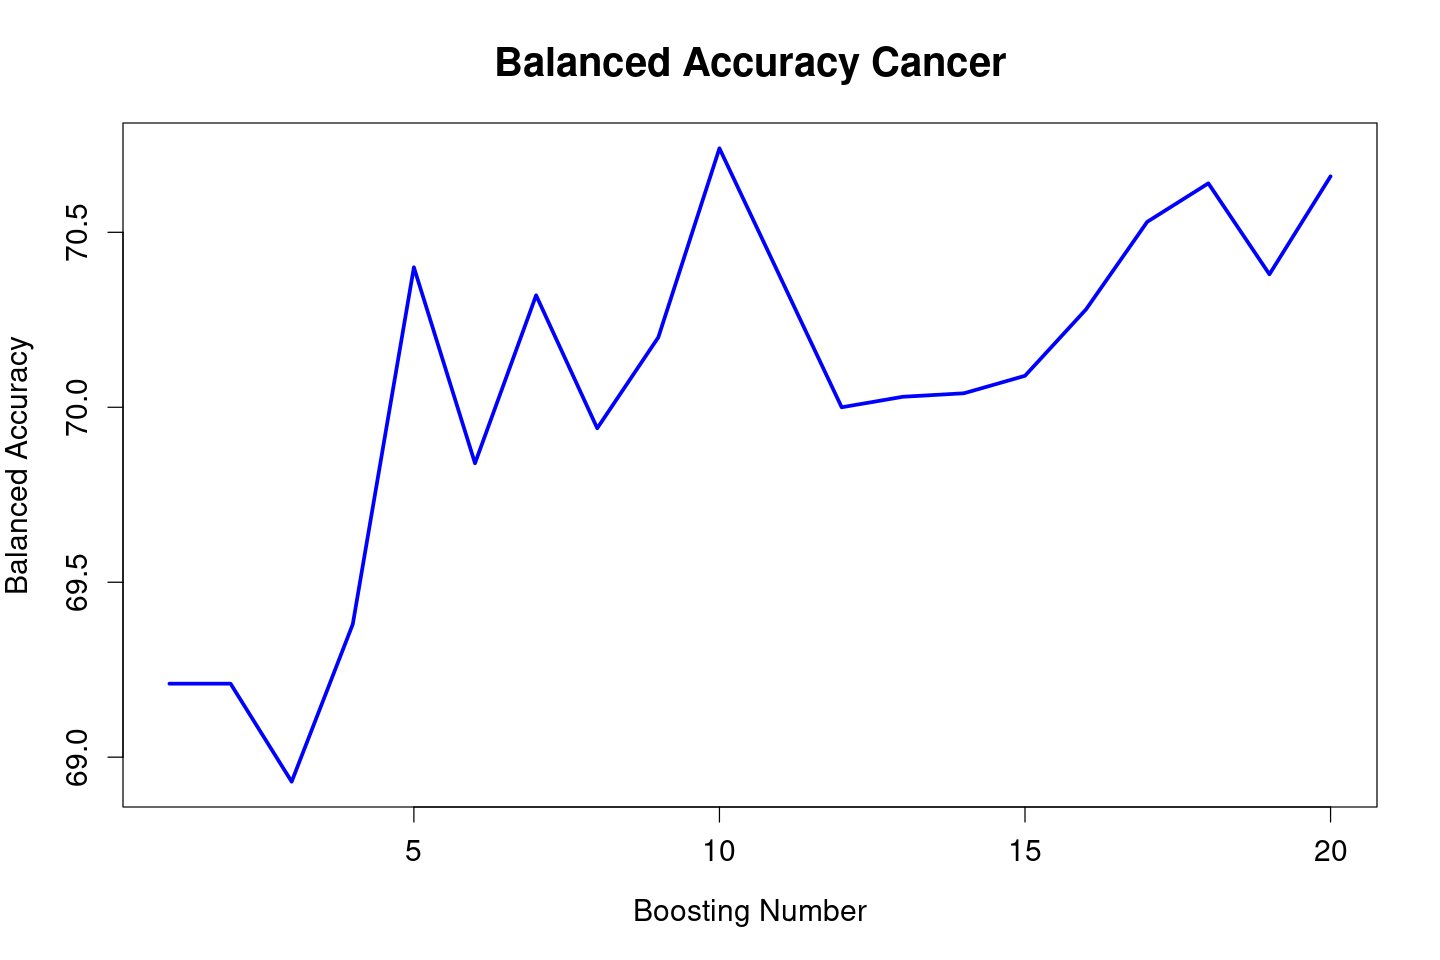

In [29]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
plot(dfbalaccur$boostn,dfbalaccur$balaccur,
#      xlim=c(0, 20), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Boosting Number",
     ylab="Balanced Accuracy",
     main=paste("Balanced Accuracy Cancer"),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

In [30]:
maxacboost<-dfbalaccur$boostn[which.max(dfbalaccur$balaccur)]
maxaccu<-dfbalaccur$balaccur[which.max(dfbalaccur$balaccur)]
print(paste("The best balanced accuracy is obtained at boost =",maxacboost))
dfmaxacc<-rbind(dfmaxacc,data.frame(boostnmbr=maxacboost,balancedAccur=maxaccu, disease=diseaseName))

[1] "The best balanced accuracy is obtained at boost = 10"


## LUNG DISEASE

In [31]:
diseaseName<-"CHCCOPD2"
dfbalaccur<-data.frame()
for(bst in seq(1,20,by=1)){
    LUNG <- fullDT(undersampleLUNG,test,outputfield=diseaseName,boost=bst,plot=TRUE)
    LUNG$distance<-sqrt(((100-LUNG$tpr)^2)+((LUNG$fpr)^2))
    balacc<-LUNG$balancedacc[which.min(LUNG$distance)]
    dfbalaccur<-rbind(dfbalaccur,data.frame(boostn=bst,balaccur=balacc))
}

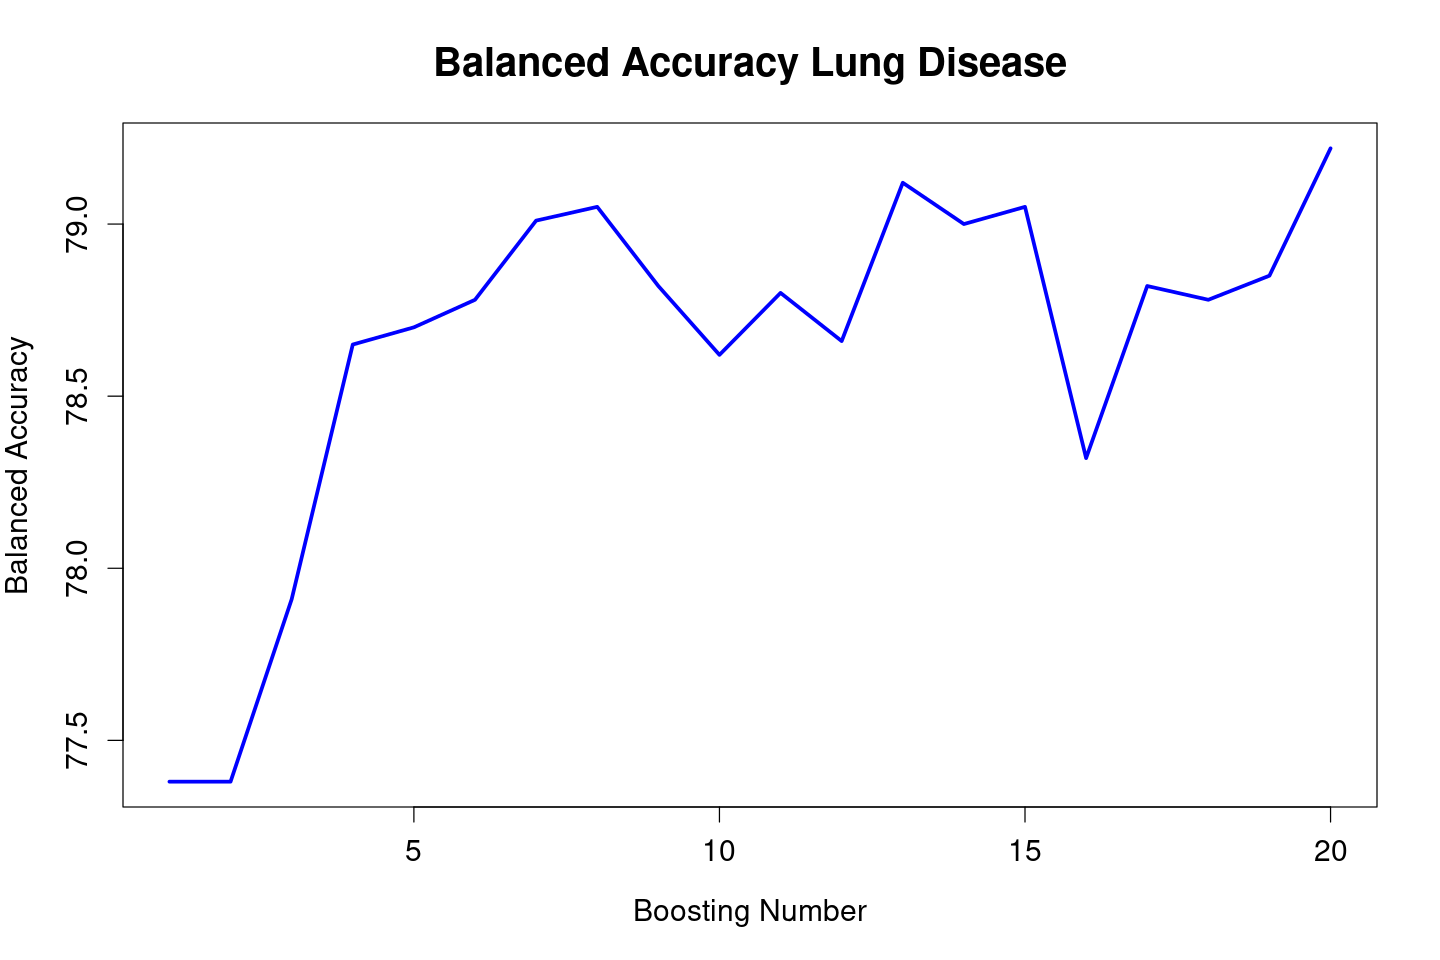

In [32]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
plot(dfbalaccur$boostn,dfbalaccur$balaccur,
#      xlim=c(0, 20), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Boosting Number",
     ylab="Balanced Accuracy",
     main=paste("Balanced Accuracy Lung Disease"),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

In [33]:
maxacboost<-dfbalaccur$boostn[which.max(dfbalaccur$balaccur)]
maxaccu<-dfbalaccur$balaccur[which.max(dfbalaccur$balaccur)]
print(paste("The best balanced accuracy is obtained at boost =",maxacboost))
dfmaxacc<-rbind(dfmaxacc,data.frame(boostnmbr=maxacboost,balancedAccur=maxaccu, disease=diseaseName))

[1] "The best balanced accuracy is obtained at boost = 20"


## DIABETES

In [34]:
DIAB <- fullDT(undersampleDIAB,test,outputfield="DIABETE4",boost=20,plot=TRUE)

In [35]:
diseaseName<-"DIABETE4"
dfbalaccur<-data.frame()
for(bst in seq(1,20,by=1)){
    DIAB <- fullDT(undersampleDIAB,test,outputfield=diseaseName,boost=bst,plot=TRUE)
    DIAB$distance<-sqrt(((100-DIAB$tpr)^2)+((DIAB$fpr)^2))
    balacc<-DIAB$balancedacc[which.min(DIAB$distance)]
    dfbalaccur<-rbind(dfbalaccur,data.frame(boostn=bst,balaccur=balacc))
}

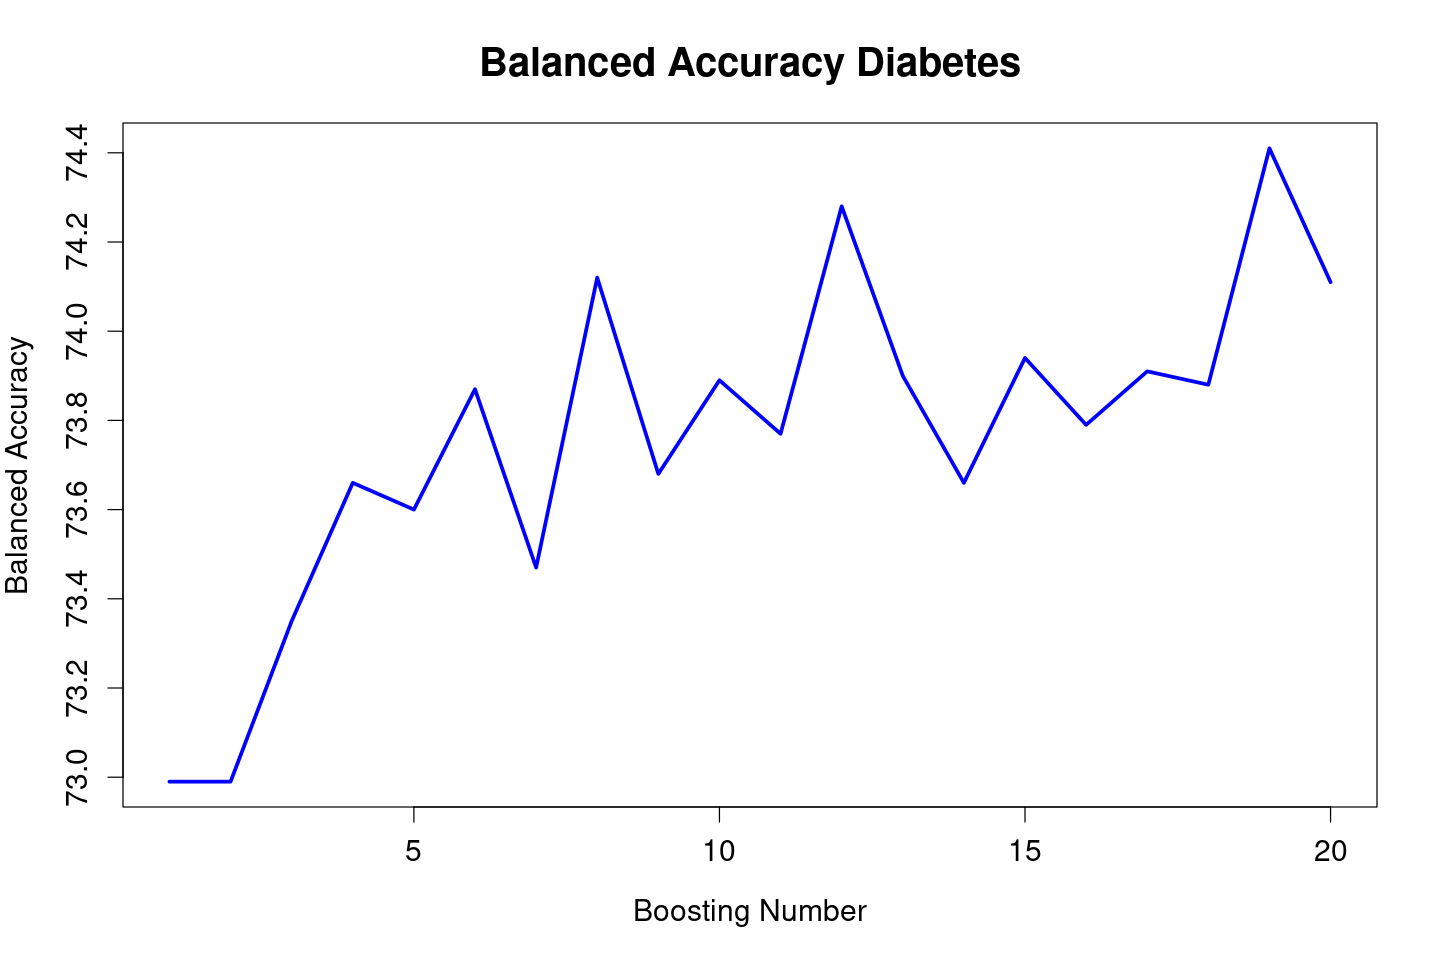

In [36]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
plot(dfbalaccur$boostn,dfbalaccur$balaccur,
#      xlim=c(0, 20), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Boosting Number",
     ylab="Balanced Accuracy",
     main=paste("Balanced Accuracy Diabetes"),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

In [37]:
maxacboost<-dfbalaccur$boostn[which.max(dfbalaccur$balaccur)]
maxaccu<-dfbalaccur$balaccur[which.max(dfbalaccur$balaccur)]
print(paste("The best balanced accuracy is obtained at boost =",maxacboost))
dfmaxacc<-rbind(dfmaxacc,data.frame(boostnmbr=maxacboost,balancedAccur=maxaccu, disease=diseaseName))

[1] "The best balanced accuracy is obtained at boost = 19"


In [38]:
dfmaxacc

boostnmbr,balancedAccur,disease
<dbl>,<dbl>,<chr>
10,66.10,ASTHMA3
17,81.71,CVDCRHD4
12,73.41,CHCSCNCR
13,74.27,CHCKDNY2
11,73.61,HAVARTH4
10,70.74,CHCOCNCR
20,79.22,CHCCOPD2
19,74.41,DIABETE4


# Metric evaluation with big dataset

After determining the ideal boost number hyperparameter for every disease, the C50 model used that boost number to explore the behaviour of other metrics like specificity, sensitivity, threat score and miss rate for a range of thresholds between 0 and 1. That was done to investigate the trends of those metrics and with the help of the Euclidean distance metric determine the ideal outcome of the C50 classifier.

In [39]:
# In this step the whole dataset was used (named 'brfssCleaned') for a more complete training of the algorithm to yield ideal results:
newDataset <- read.csv(file = 'brfssCleaned.csv')
head(newDataset)

,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,EXERANY2,SLEPTIM1,⋯,ECIGARET,QSTVER,QSTLANG,METSTAT,URBSTAT,PRACE1,AGEG5YR,HTM4,BMI5,DROCDY3_
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,⋯,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.25,0.1000000,1,1,1,0,1.00,0,0.1739130,⋯,0,0,0,0,0,0.0000000,0.5833333,0.5266667,0.05300312,0
2,1,0.50,0.0000000,0,0,0,0,0.25,0,0.2608696,⋯,1,0,0,0,0,0.1428571,0.7500000,0.4800000,0.19858813,0
3,1,0.50,0.0000000,0,0,0,1,0.25,0,0.2608696,⋯,1,0,0,0,0,0.1428571,0.7500000,0.5466667,0.18847718,0
4,1,0.00,0.0000000,0,0,1,1,0.50,1,0.2173913,⋯,1,0,0,0,0,0.0000000,1.0000000,0.5133333,0.18847718,0
5,1,0.25,0.0000000,0,0,0,1,0.25,0,0.2608696,⋯,1,0,0,0,0,0.0000000,1.0000000,0.5133333,0.09628515,0
6,0,0.75,0.6666667,1,0,0,1,0.50,0,0.3043478,⋯,0,0,0,1,0,0.0000000,0.7500000,0.5600000,0.16849902,0


In [40]:
# Below we are again setting the target diseases as factors in the dataset:
newDataset$ASTHMA3 <- as.factor(newDataset$ASTHMA3) # Asthma
newDataset$CVDCRHD4 <- as.factor(newDataset$CVDCRHD4) # Cardiovascular Disease
newDataset$CHCSCNCR <- as.factor(newDataset$CHCSCNCR) # Skin Cancer
newDataset$CHCKDNY2 <- as.factor(newDataset$CHCKDNY2) # Kidney Disease 
newDataset$HAVARTH4 <- as.factor(newDataset$HAVARTH4) # Arthritis
newDataset$CHCOCNCR <- as.factor(newDataset$CHCOCNCR) # Skin Cancer
newDataset$CHCCOPD2 <- as.factor(newDataset$CHCCOPD2) # Pulmonary Disease
newDataset$DIABETE4 <- as.factor(newDataset$DIABETE4) # Diabetes

In [41]:
#Train and test data split
set.seed(100)
ind <- sample(nrow(newDataset), 0.7*nrow(newDataset), replace = FALSE)
train <- newDataset[ind,]
test <- newDataset[-ind,]

In [42]:
# creating balanced undersamples of the training data to train fullDT() (C50) on
undersampleASTH <- ovun.sample(ASTHMA3~., data = train, method = "under", p = 0.5)$data
undersampleHEART <- ovun.sample(CVDCRHD4~., data = train, method = "under", p = 0.5)$data
undersampleSKIN <- ovun.sample(CHCSCNCR~., data = train, method = "under", p = 0.5)$data
undersampleKIDNEY <- ovun.sample(CHCKDNY2~., data = train, method = "under", p = 0.5)$data
undersampleARTH <- ovun.sample(HAVARTH4~., data = train, method = "under", p = 0.5)$data
undersampleCANCER <- ovun.sample(CHCOCNCR~., data = train, method = "under", p = 0.5)$data
undersampleLUNG <- ovun.sample(CHCCOPD2~., data = train, method = "under", p = 0.5)$data
undersampleDIAB <- ovun.sample(DIABETE4~., data = train, method = "under", p = 0.5)$data

In [43]:
# ncol(train)
head(undersampleASTH)

,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,EXERANY2,SLEPTIM1,⋯,ECIGARET,QSTVER,QSTLANG,METSTAT,URBSTAT,PRACE1,AGEG5YR,HTM4,BMI5,DROCDY3_
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,⋯,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.25,0.0,0.03333333,0,0,1,0.25,0,0.2173913,⋯,0,0.00000000,0,0,0,0.0000000,0.8333333,0.4600000,0.2196505,0.00
2,1,0.25,0.0,0.00000000,0,0,1,0.25,0,0.3043478,⋯,1,0.15384615,0,0,0,0.1428571,0.6666667,0.4933333,0.1884772,0.00
3,1,0.50,0.0,0.00000000,0,0,0,0.25,0,0.3043478,⋯,1,0.76923077,0,0,0,0.4285714,0.5000000,0.4800000,0.1290360,0.00
4,1,0.75,0.1,0.00000000,0,0,1,0.25,1,0.2173913,⋯,1,0.07692308,0,0,0,0.1428571,0.9166667,0.4400000,0.1297304,0.00
5,0,0.25,0.0,0.00000000,0,0,1,0.25,0,0.2608696,⋯,1,0.92307692,0,0,0,0.0000000,0.4166667,0.6466667,0.2471936,0.07
6,1,0.00,0.0,0.00000000,0,0,1,0.25,1,0.2173913,⋯,1,0.76923077,0,0,0,0.0000000,0.5000000,0.5466667,0.1336651,0.00


## ASTHMA

In [44]:
# Here we are training as well as testing the fullDT algorithm for the ideal hyperparameters for each disease
ASTH <- fullDT(undersampleASTH,test,outputfield="ASTHMA3",boost=10,plot=TRUE)

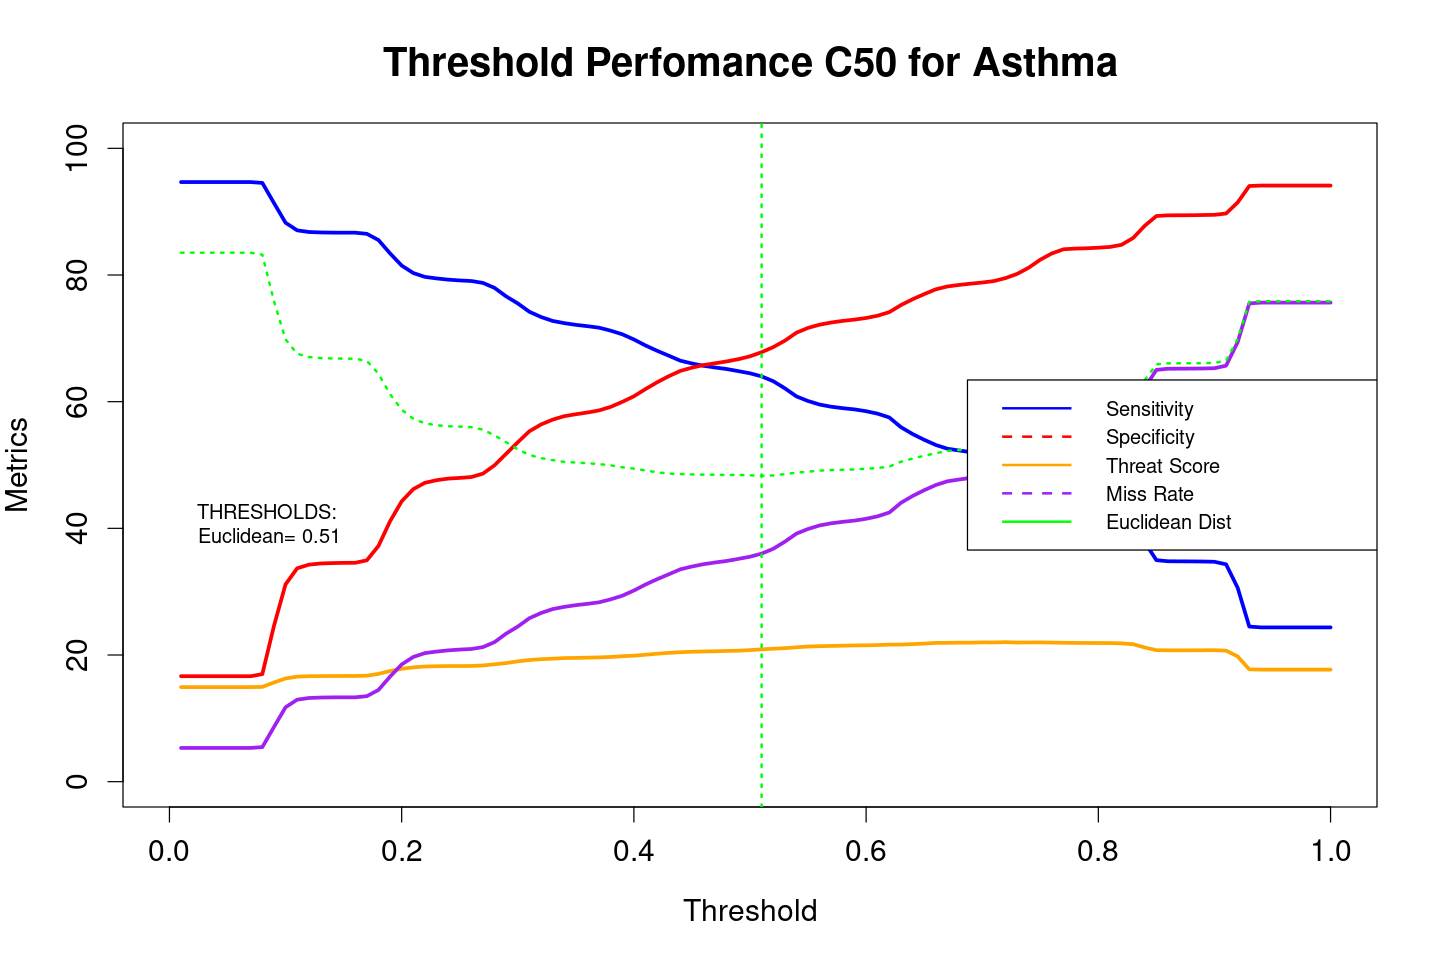

In [45]:
# Most of the below equations were modified from the functions of lab 4
# Euclidean distance sqrt((1 − sensitivity)^2+ (1 − specificity)^2)
# To the top left (i.e. perfect classifier)
ASTH$distance<-sqrt(((100-ASTH$tpr)^2)+((ASTH$fpr)^2)) 

# Euclidean distance to "perfect" classifier (smallest the best)
# use which.min() to return a single index to the lowest value in the vector
minEuclidean<-ASTH$x[which.min(ASTH$distance)]

plot(ASTH$x,ASTH$tpr,
     xlim=c(0, 1), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Threshold",
     ylab="Metrics",
     main=paste("Threshold Perfomance C50 for Asthma"),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

# Plot the specificity (100-FPR)
lines(ASTH$x,100-ASTH$fpr,type="l",col="red",lwd=3,lty=1)

# plot the threat score
lines(ASTH$x,ASTH$threatScore,type="l",col="orange",lwd=3,lty=1)

# plot the miss rate
lines(ASTH$x,ASTH$fnr,type="l",col="purple",lwd=3,lty=1)


# The point where specificity and sensitivity are the same
crosspoint<-ASTH$x[which.min(ASTH$distance)]

#     if (!is.na(crosspoint)){
#       if ((crosspoint<1) & (crosspoint>0))
#         abline(v=crosspoint,col="red",lty=3,lwd=2)
#     }

# Plot the Euclidean distance to "perfect" classifier (smallest the best)
lines(ASTH$x,ASTH$distance,type="l",col="green",lwd=2,lty=3)

# Plot the min distance, as might be more (311019NRT check it is within range)
if ((minEuclidean<1) & (minEuclidean>0))
  abline(v=minEuclidean,col="green",lty=3,lwd=2)



legend("right",c("Sensitivity","Specificity","Threat Score","Miss Rate","Euclidean Dist"),col=c("blue","red","orange","purple", "green"),cex=1,lty=1:2,lwd=2)
text(x=0,y=50, adj = c(-0.2,2),cex=1,col="black",paste("THRESHOLDS:\nEuclidean=",minEuclidean))

The plot a above was done to understand the trends of all of the metrics for 100 thresholds between 0 and 1 with incerements of 0.01. The vertical green line shows the ideal location of the threshold corresponding to the nature of our dataset.

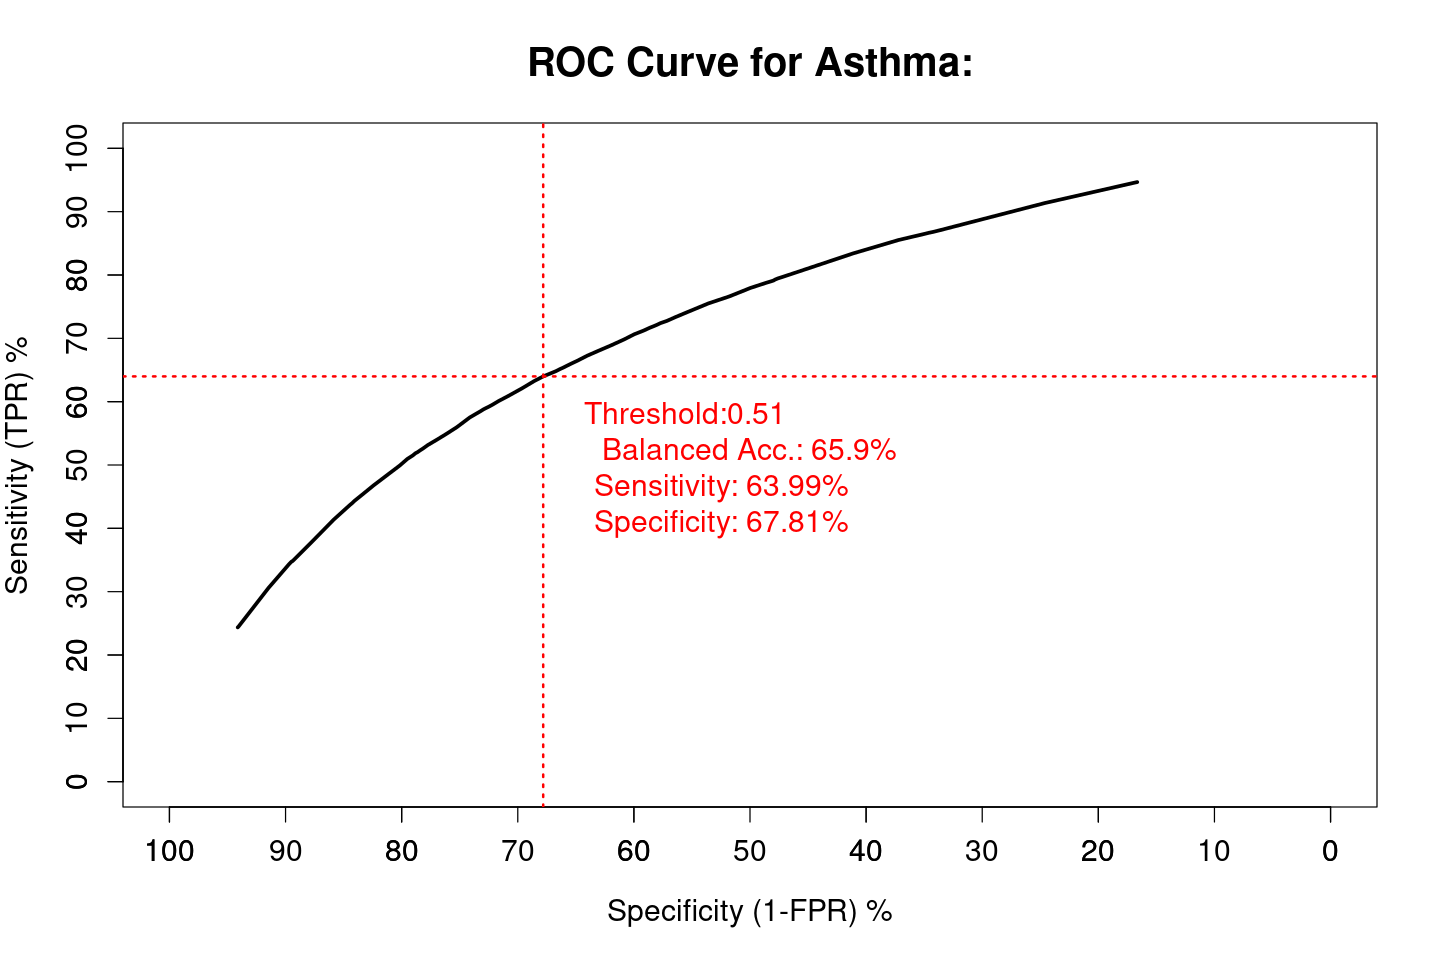

In [46]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
sensitivityROC<-ASTH$tpr[which.min(ASTH$distance)] # calculates the sensitivity for the ideal threshold
specificityROC<-100-ASTH$fpr[which.min(ASTH$distance)] # calculates the specificity for the ideal threshold
balacc<-ASTH$balancedacc[which.min(ASTH$distance)] # calculates the balanced accuracy for the ideal threshold

plot(100-ASTH$fpr,ASTH$tpr,type="l",lwd=3, col="black",
     main=paste("ROC Curve for Asthma:"),
     xlab="Specificity (1-FPR) %",
     ylab="Sensitivity (TPR) %",
     xlim=c(100,0),
     ylim=c(0,100),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

axis(1, seq(0.0,100,10), cex.axis=1.5)
axis(2, seq(0.0,100,10), cex.axis=1.5)

#Add crosshairs to the graph
abline(h=sensitivityROC,col="red",lty=3,lwd=2)
abline(v=specificityROC,col="red",lty=3,lwd=2)

annotate<-paste("Threshold:",round(minEuclidean,digits=4L),
                "\nBalanced Acc.: ",round(balacc,digits=2L),
                "%\nSensitivity: ",round(sensitivityROC,digits=2L),
                "%\nSpecificity: ",round(specificityROC,digits=2L),"%",sep="")
# axis(1,cex.axis=2)
text(x=specificityROC, y=sensitivityROC, adj = c(-0.2,1.2),cex=1.5, col="red",annotate)

In [47]:
bigDatadfBalac<-data.frame() # Will store the balanced accuracies for the ideal threshold for each disease
bigDatadfBalac<-rbind(bigDatadfBalac,data.frame(AccuracyBalanced=balacc,diseaseType="Asthma")) # Concatenates the results of the disease

In [48]:
bigDatadfBalac

AccuracyBalanced,diseaseType
<dbl>,<chr>
65.9,Asthma


## HEART DISEASE

In [49]:
HEART <- fullDT(undersampleHEART,test,outputfield="CVDCRHD4",boost=17,plot=TRUE)

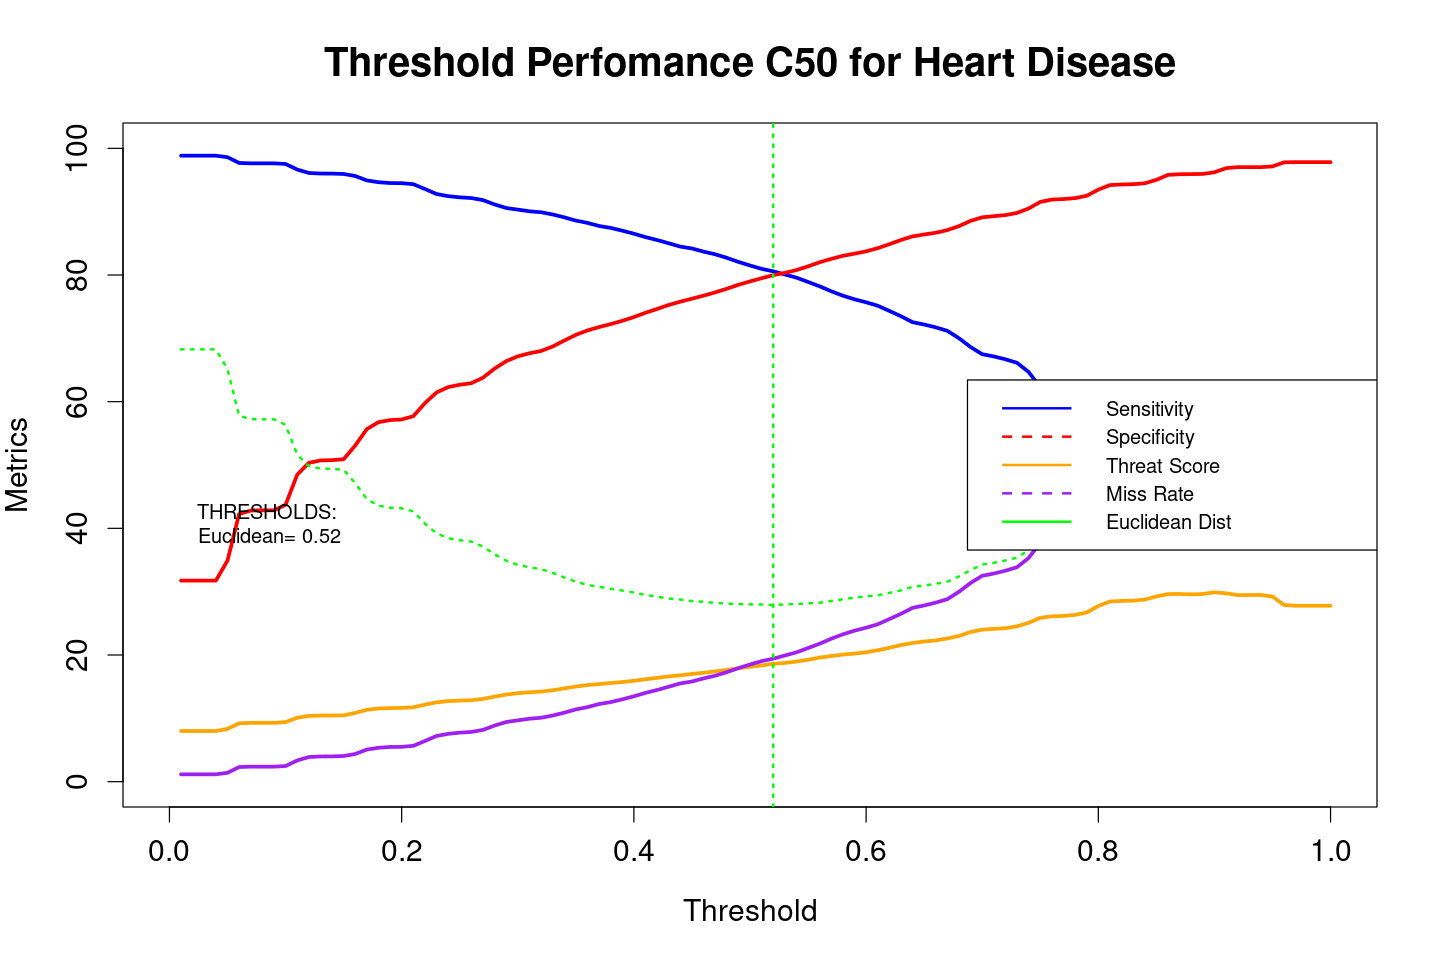

In [50]:
# options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
# Euclidean distance sqrt((1 − sensitivity)^2+ (1 − specificity)^2)
# To the top left (i.e. perfect classifier)
HEART$distance<-sqrt(((100-HEART$tpr)^2)+((HEART$fpr)^2))

# Euclidean distance to "perfect" classifier (smallest the best)
# use which.min() to return a single index to the lowest value in the vector
minEuclidean<-HEART$x[which.min(HEART$distance)]

plot(HEART$x,HEART$tpr,
     xlim=c(0, 1), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Threshold",
     ylab="Metrics",
     main=paste("Threshold Perfomance C50 for Heart Disease"), 
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

# Plot the specificity (100-FPR)
lines(HEART$x,100-HEART$fpr,type="l",col="red",lwd=3,lty=1)

# plot the threat score
lines(HEART$x,HEART$threatScore,type="l",col="orange",lwd=3,lty=1)

# plot the miss rate
lines(HEART$x,HEART$fnr,type="l",col="purple",lwd=3,lty=1)


# The point where specificity and sensitivity are the same
crosspoint<-HEART$x[which.min(HEART$distance)]

#     if (!is.na(crosspoint)){
#       if ((crosspoint<1) & (crosspoint>0))
#         abline(v=crosspoint,col="red",lty=3,lwd=2)
#     }

# Plot the Euclidean distance to "perfect" classifier (smallest the best)
lines(HEART$x,HEART$distance,type="l",col="green",lwd=2,lty=3)

# Plot the min distance, as might be more (311019NRT check it is within range)
if ((minEuclidean<1) & (minEuclidean>0))
  abline(v=minEuclidean,col="green",lty=3,lwd=2)

# Youdan (Vertical distance between the 45 degree line and the point on the ROC curve )
#lines(HEART$x,HEART$youdan,type="l",col="purple",lwd=2,lty=3)

#if ((maxYoudan<1) & (maxYoudan>0))
#  abline(v=maxYoudan,col="purple",lty=3,lwd=2)

legend("right",c("Sensitivity","Specificity","Threat Score","Miss Rate","Euclidean Dist"),col=c("blue","red","orange","purple", "green"),cex=1,lty=1:2,lwd=2)
text(x=0,y=50, adj = c(-0.2,2),cex=1,col="black",paste("THRESHOLDS:\nEuclidean=",minEuclidean))

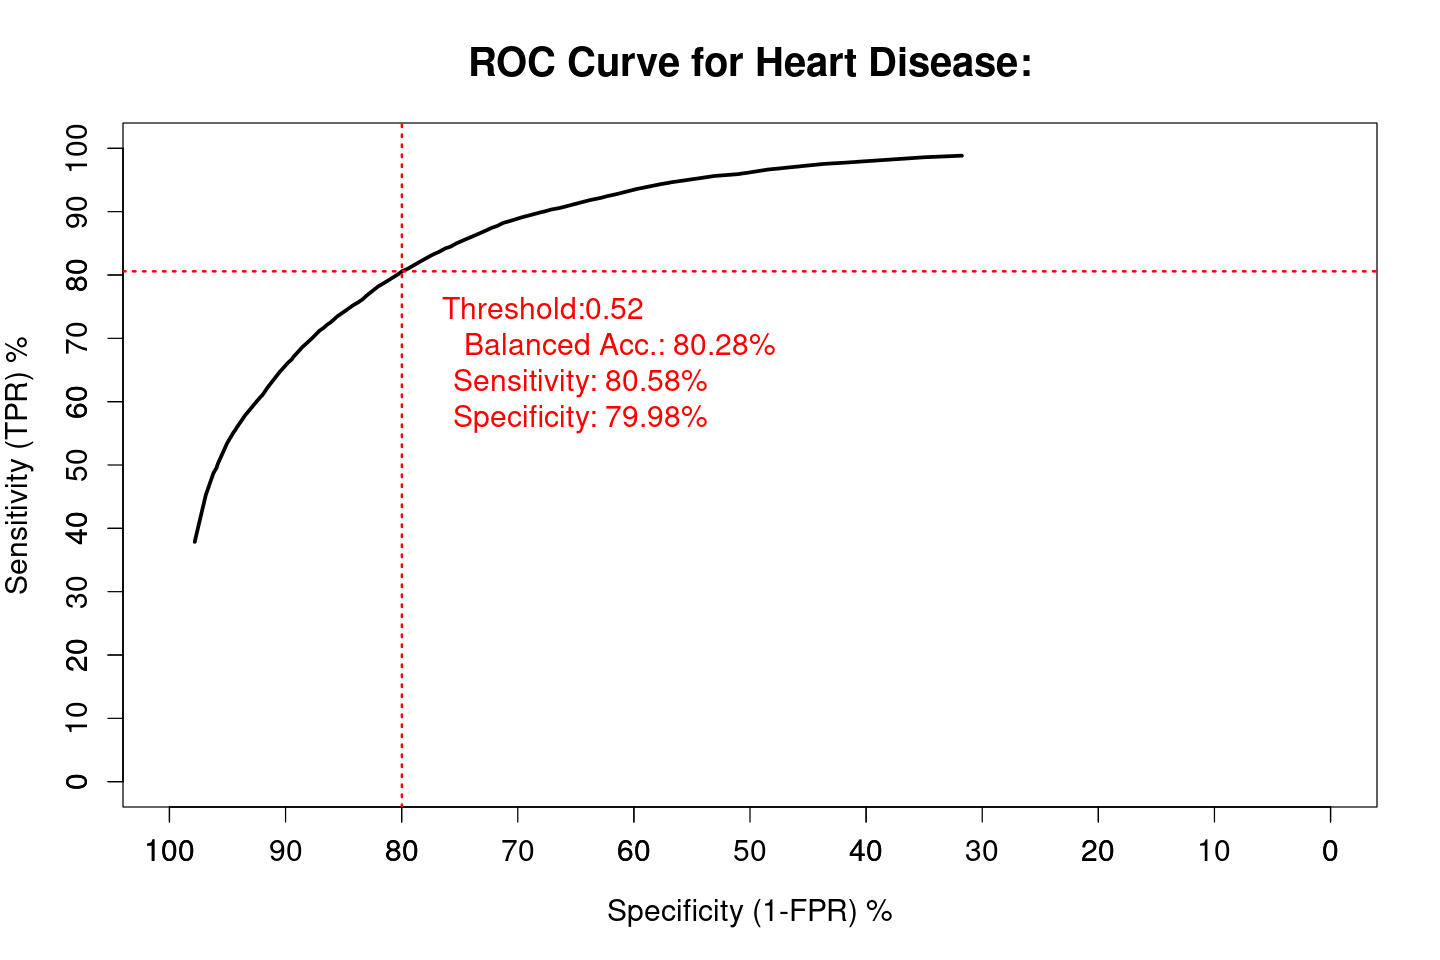

In [51]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
sensitivityROC<-HEART$tpr[which.min(HEART$distance)]
specificityROC<-100-HEART$fpr[which.min(HEART$distance)]
balacc<-HEART$balancedacc[which.min(HEART$distance)]


plot(100-HEART$fpr,HEART$tpr,type="l",lwd=3, col="black",
     main=paste("ROC Curve for Heart Disease:"),
     xlab="Specificity (1-FPR) %",
     ylab="Sensitivity (TPR) %",
     xlim=c(100,0),
     ylim=c(0,100),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

axis(1, seq(0.0,100,10), cex.axis=1.5)
axis(2, seq(0.0,100,10), cex.axis=1.5)

#Add crosshairs to the graph
abline(h=sensitivityROC,col="red",lty=3,lwd=2)
abline(v=specificityROC,col="red",lty=3,lwd=2)

annotate<-paste("Threshold:",round(minEuclidean,digits=4L),
                "\nBalanced Acc.: ",round(balacc,digits=2L),
                "%\nSensitivity: ",round(sensitivityROC,digits=2L),
                "%\nSpecificity: ",round(specificityROC,digits=2L),"%",sep="")
# axis(1,cex.axis=2)
text(x=specificityROC, y=sensitivityROC, adj = c(-0.2,1.2),cex=1.5, col="red",annotate)

In [52]:
bigDatadfBalac<-rbind(bigDatadfBalac,data.frame(AccuracyBalanced=balacc,diseaseType="Heart Disease"))

## SKIN CANCER

In [53]:
SKIN <- fullDT(undersampleSKIN,test,outputfield="CHCSCNCR",boost=12,plot=TRUE)

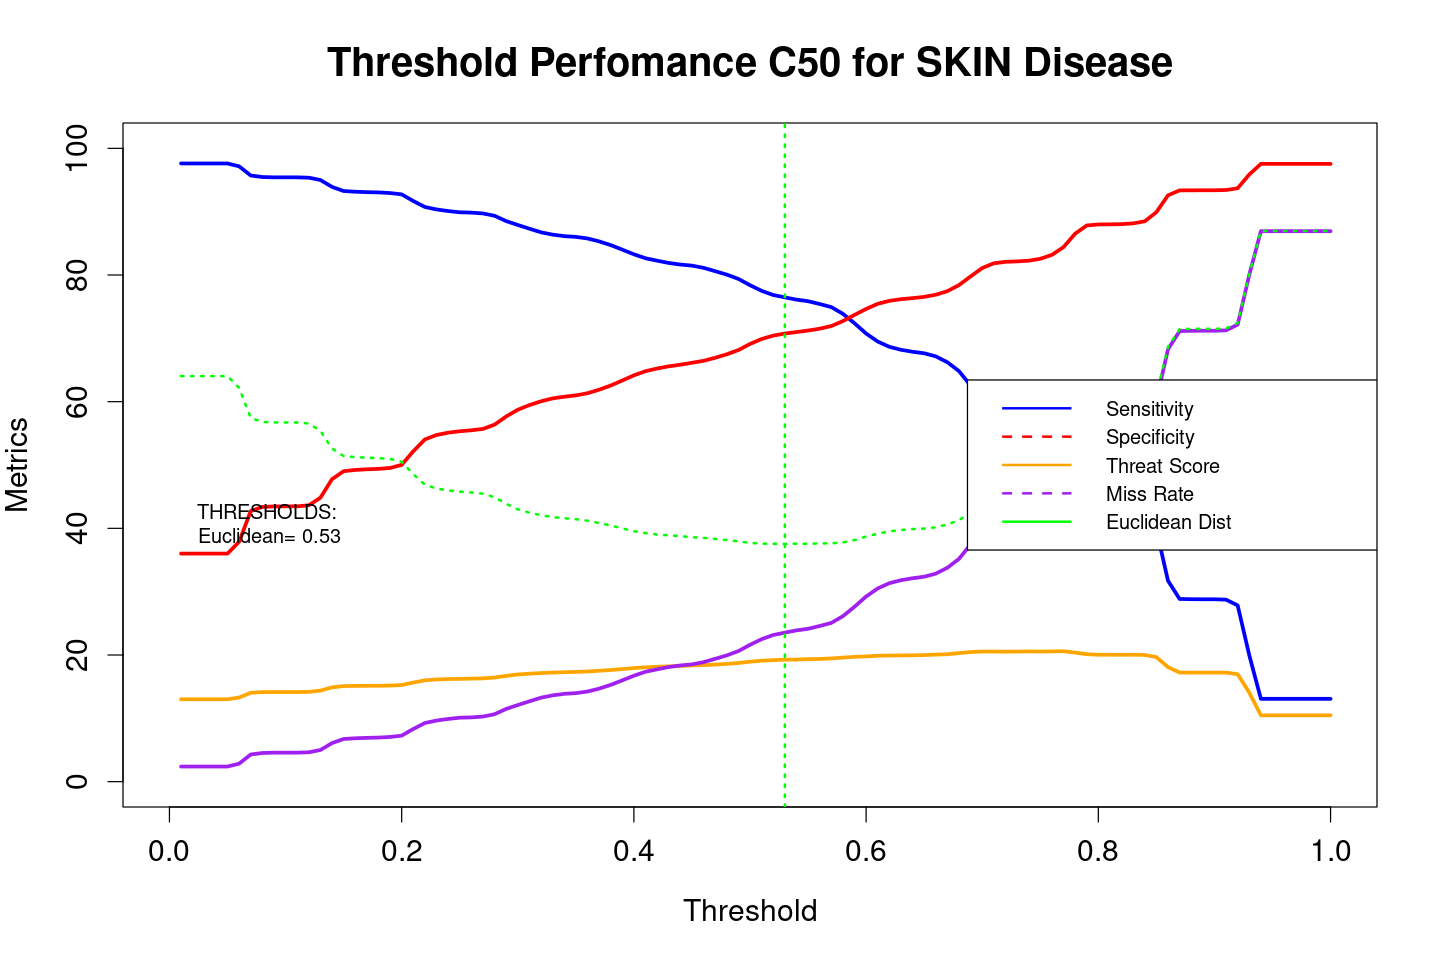

In [54]:
# options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
# Euclidean distance sqrt((1 − sensitivity)^2+ (1 − specificity)^2)
# To the top left (i.e. perfect classifier)
SKIN$distance<-sqrt(((100-SKIN$tpr)^2)+((SKIN$fpr)^2))

# Euclidean distance to "perfect" classifier (smallest the best)
# use which.min() to return a single index to the lowest value in the vector
minEuclidean<-SKIN$x[which.min(SKIN$distance)]

plot(SKIN$x,SKIN$tpr,
     xlim=c(0, 1), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Threshold",
     ylab="Metrics",
     main=paste("Threshold Perfomance C50 for SKIN Disease"), 
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

# Plot the specificity (100-FPR)
lines(SKIN$x,100-SKIN$fpr,type="l",col="red",lwd=3,lty=1)

# plot the threat score
lines(SKIN$x,SKIN$threatScore,type="l",col="orange",lwd=3,lty=1)

# plot the miss rate
lines(SKIN$x,SKIN$fnr,type="l",col="purple",lwd=3,lty=1)


# The point where specificity and sensitivity are the same
crosspoint<-SKIN$x[which.min(SKIN$distance)]

#     if (!is.na(crosspoint)){
#       if ((crosspoint<1) & (crosspoint>0))
#         abline(v=crosspoint,col="red",lty=3,lwd=2)
#     }

# Plot the Euclidean distance to "perfect" classifier (smallest the best)
lines(SKIN$x,SKIN$distance,type="l",col="green",lwd=2,lty=3)

# Plot the min distance, as might be more (311019NRT check it is within range)
if ((minEuclidean<1) & (minEuclidean>0))
  abline(v=minEuclidean,col="green",lty=3,lwd=2)

# Youdan (Vertical distance between the 45 degree line and the point on the ROC curve )
#lines(SKIN$x,SKIN$youdan,type="l",col="purple",lwd=2,lty=3)

#if ((maxYoudan<1) & (maxYoudan>0))
#  abline(v=maxYoudan,col="purple",lty=3,lwd=2)

legend("right",c("Sensitivity","Specificity","Threat Score","Miss Rate","Euclidean Dist"),col=c("blue","red","orange","purple", "green"),cex=1,lty=1:2,lwd=2)
text(x=0,y=50, adj = c(-0.2,2),cex=1,col="black",paste("THRESHOLDS:\nEuclidean=",minEuclidean))

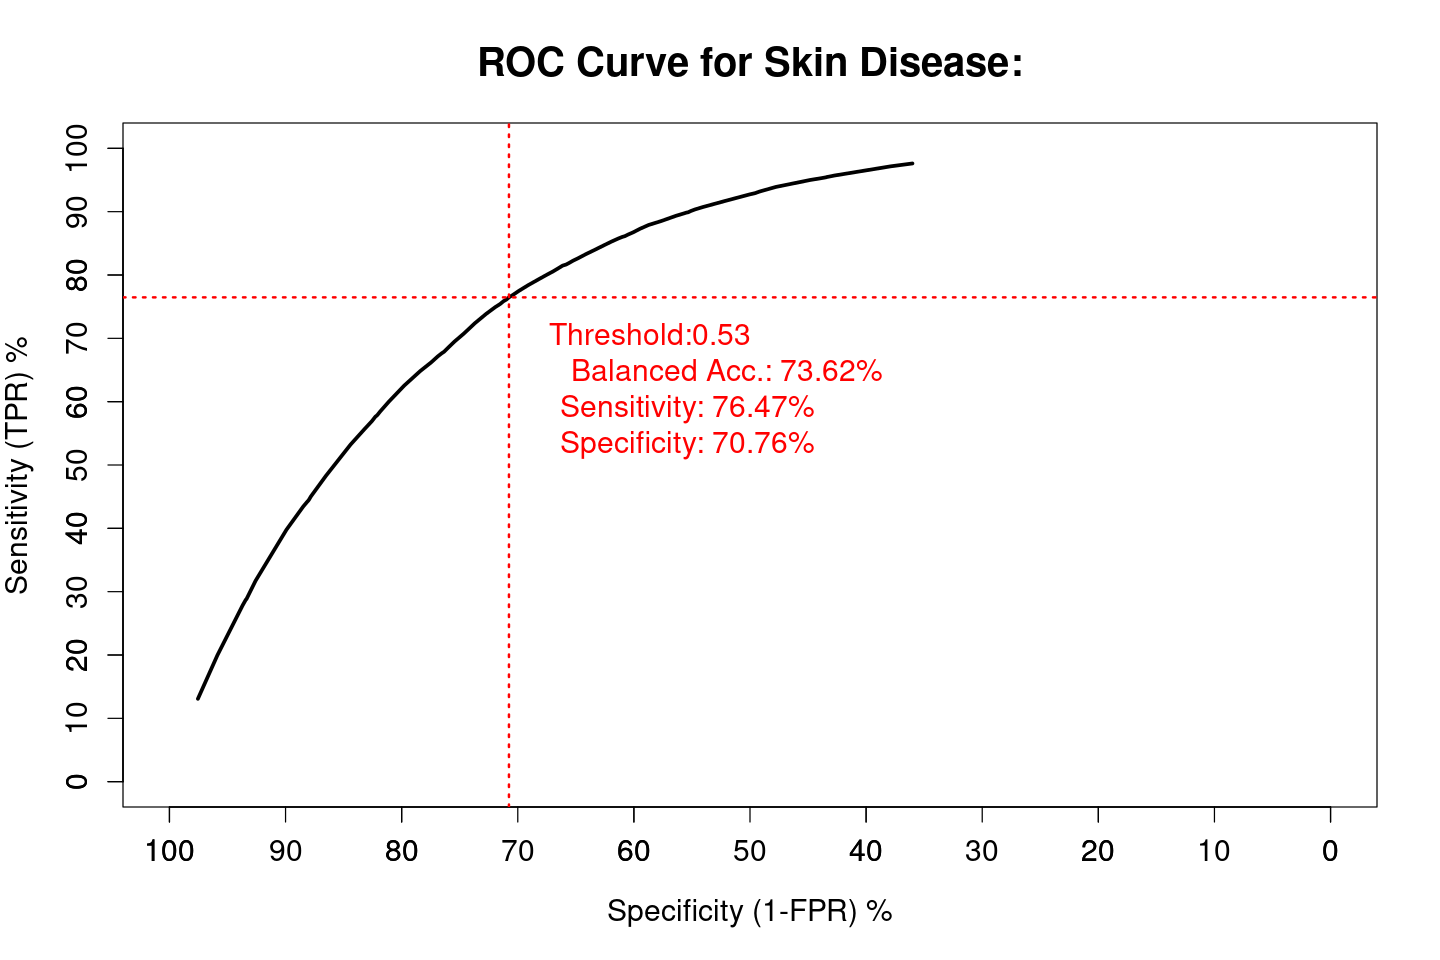

In [55]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
sensitivityROC<-SKIN$tpr[which.min(SKIN$distance)]
specificityROC<-100-SKIN$fpr[which.min(SKIN$distance)]
balacc<-SKIN$balancedacc[which.min(SKIN$distance)]


plot(100-SKIN$fpr,SKIN$tpr,type="l",lwd=3, col="black",
     main=paste("ROC Curve for Skin Disease:"),
     xlab="Specificity (1-FPR) %",
     ylab="Sensitivity (TPR) %",
     xlim=c(100,0),
     ylim=c(0,100),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

axis(1, seq(0.0,100,10), cex.axis=1.5)
axis(2, seq(0.0,100,10), cex.axis=1.5)

#Add crosshairs to the graph
abline(h=sensitivityROC,col="red",lty=3,lwd=2)
abline(v=specificityROC,col="red",lty=3,lwd=2)

annotate<-paste("Threshold:",round(minEuclidean,digits=4L),
                "\nBalanced Acc.: ",round(balacc,digits=2L),
                "%\nSensitivity: ",round(sensitivityROC,digits=2L),
                "%\nSpecificity: ",round(specificityROC,digits=2L),"%",sep="")
# axis(1,cex.axis=2)
text(x=specificityROC, y=sensitivityROC, adj = c(-0.2,1.2),cex=1.5, col="red",annotate)

In [56]:
bigDatadfBalac<-rbind(bigDatadfBalac,data.frame(AccuracyBalanced=balacc,diseaseType="Skin Disease"))

## KIDNEY DISEASE

In [57]:
KIDNEY <- fullDT(undersampleKIDNEY,test,outputfield="CHCKDNY2",boost=13,plot=TRUE)

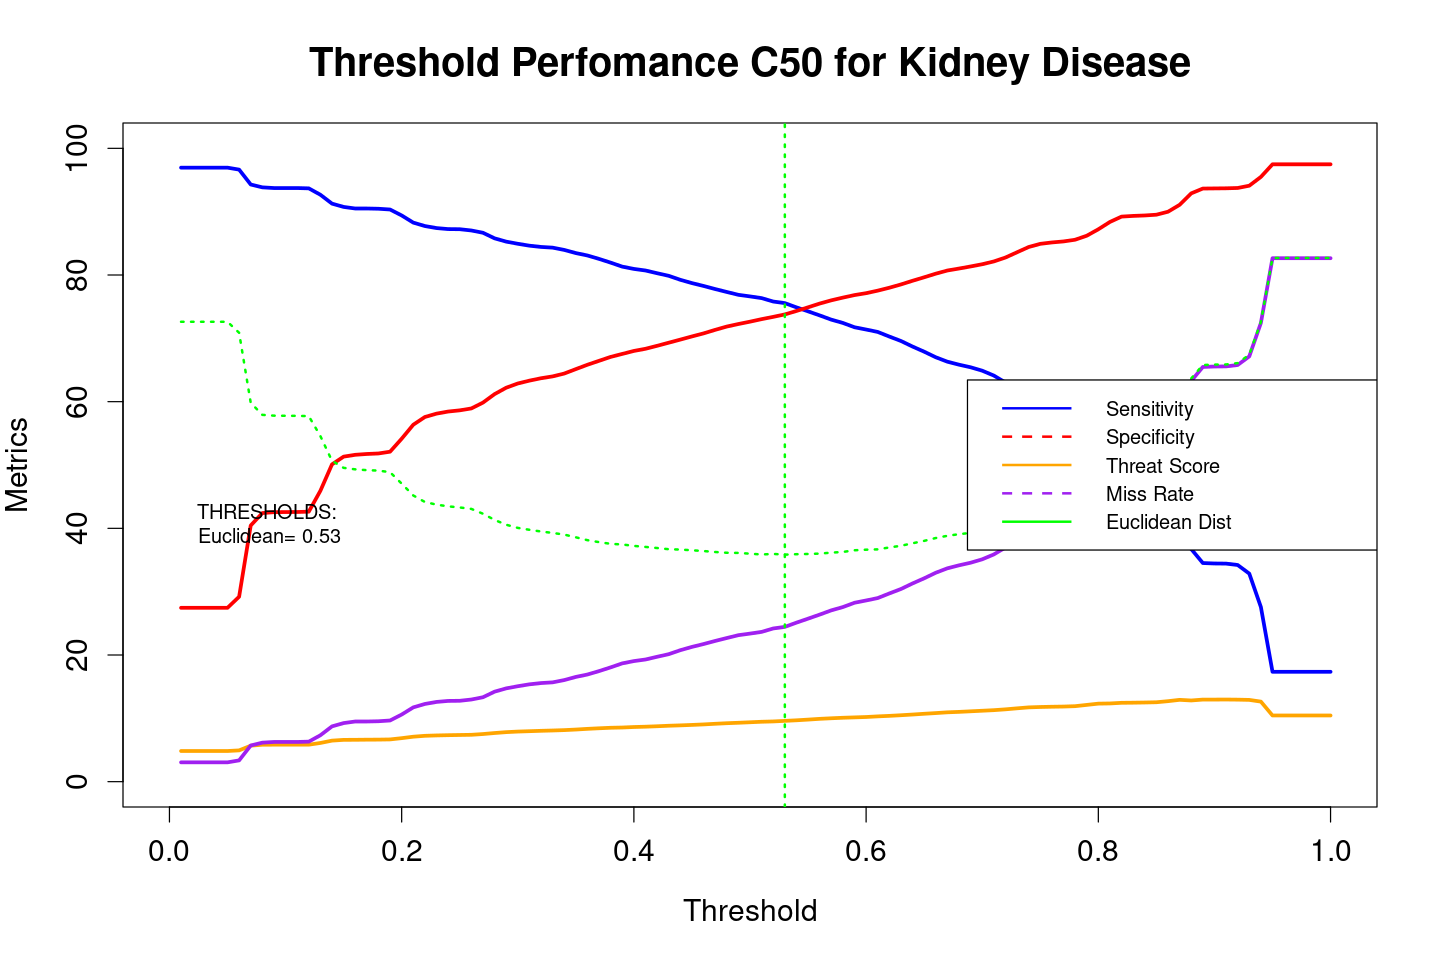

In [58]:
# options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
# Euclidean distance sqrt((1 − sensitivity)^2+ (1 − specificity)^2)
# To the top left (i.e. perfect classifier)
KIDNEY$distance<-sqrt(((100-KIDNEY$tpr)^2)+((KIDNEY$fpr)^2))

# Euclidean distance to "perfect" classifier (smallest the best)
# use which.min() to return a single index to the lowest value in the vector
minEuclidean<-KIDNEY$x[which.min(KIDNEY$distance)]

plot(KIDNEY$x,KIDNEY$tpr,
     xlim=c(0, 1), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Threshold",
     ylab="Metrics",
     main=paste("Threshold Perfomance C50 for Kidney Disease"), 
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

# Plot the specificity (100-FPR)
lines(KIDNEY$x,100-KIDNEY$fpr,type="l",col="red",lwd=3,lty=1)

# plot the threat score
lines(KIDNEY$x,KIDNEY$threatScore,type="l",col="orange",lwd=3,lty=1)

# plot the miss rate
lines(KIDNEY$x,KIDNEY$fnr,type="l",col="purple",lwd=3,lty=1)


# The point where specificity and sensitivity are the same
crosspoint<-KIDNEY$x[which.min(KIDNEY$distance)]

#     if (!is.na(crosspoint)){
#       if ((crosspoint<1) & (crosspoint>0))
#         abline(v=crosspoint,col="red",lty=3,lwd=2)
#     }

# Plot the Euclidean distance to "perfect" classifier (smallest the best)
lines(KIDNEY$x,KIDNEY$distance,type="l",col="green",lwd=2,lty=3)

# Plot the min distance, as might be more (311019NRT check it is within range)
if ((minEuclidean<1) & (minEuclidean>0))
  abline(v=minEuclidean,col="green",lty=3,lwd=2)

# Youdan (Vertical distance between the 45 degree line and the point on the ROC curve )
#lines(KIDNEY$x,KIDNEY$youdan,type="l",col="purple",lwd=2,lty=3)

#if ((maxYoudan<1) & (maxYoudan>0))
#  abline(v=maxYoudan,col="purple",lty=3,lwd=2)

legend("right",c("Sensitivity","Specificity","Threat Score","Miss Rate","Euclidean Dist"),col=c("blue","red","orange","purple", "green"),cex=1,lty=1:2,lwd=2)
text(x=0,y=50, adj = c(-0.2,2),cex=1,col="black",paste("THRESHOLDS:\nEuclidean=",minEuclidean))

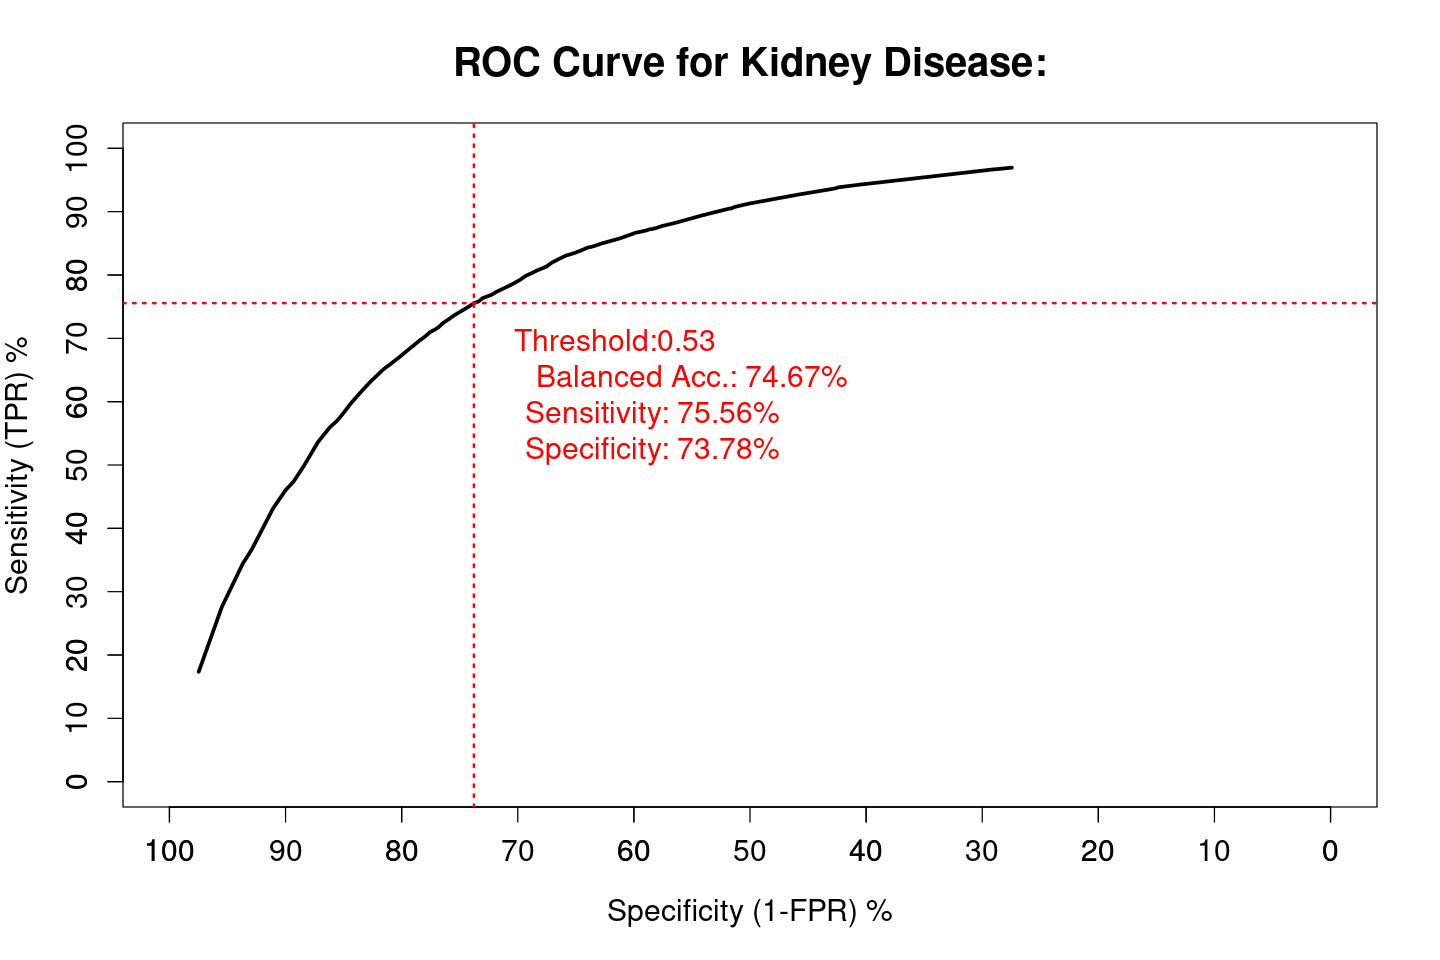

In [59]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
sensitivityROC<-KIDNEY$tpr[which.min(KIDNEY$distance)]
specificityROC<-100-KIDNEY$fpr[which.min(KIDNEY$distance)]
balacc<-KIDNEY$balancedacc[which.min(KIDNEY$distance)]


plot(100-KIDNEY$fpr,KIDNEY$tpr,type="l",lwd=3, col="black",
     main=paste("ROC Curve for Kidney Disease:"),
     xlab="Specificity (1-FPR) %",
     ylab="Sensitivity (TPR) %",
     xlim=c(100,0),
     ylim=c(0,100),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

axis(1, seq(0.0,100,10), cex.axis=1.5)
axis(2, seq(0.0,100,10), cex.axis=1.5)

#Add crosshairs to the graph
abline(h=sensitivityROC,col="red",lty=3,lwd=2)
abline(v=specificityROC,col="red",lty=3,lwd=2)

annotate<-paste("Threshold:",round(minEuclidean,digits=4L),
                "\nBalanced Acc.: ",round(balacc,digits=2L),
                "%\nSensitivity: ",round(sensitivityROC,digits=2L),
                "%\nSpecificity: ",round(specificityROC,digits=2L),"%",sep="")
# axis(1,cex.axis=2)
text(x=specificityROC, y=sensitivityROC, adj = c(-0.2,1.2),cex=1.5, col="red",annotate)

In [60]:
bigDatadfBalac<-rbind(bigDatadfBalac,data.frame(AccuracyBalanced=balacc,diseaseType="Kidney Disease"))

## ARTHRITIS

In [61]:
ARTH <- fullDT(undersampleARTH,test,outputfield="HAVARTH4",boost=11,plot=TRUE)

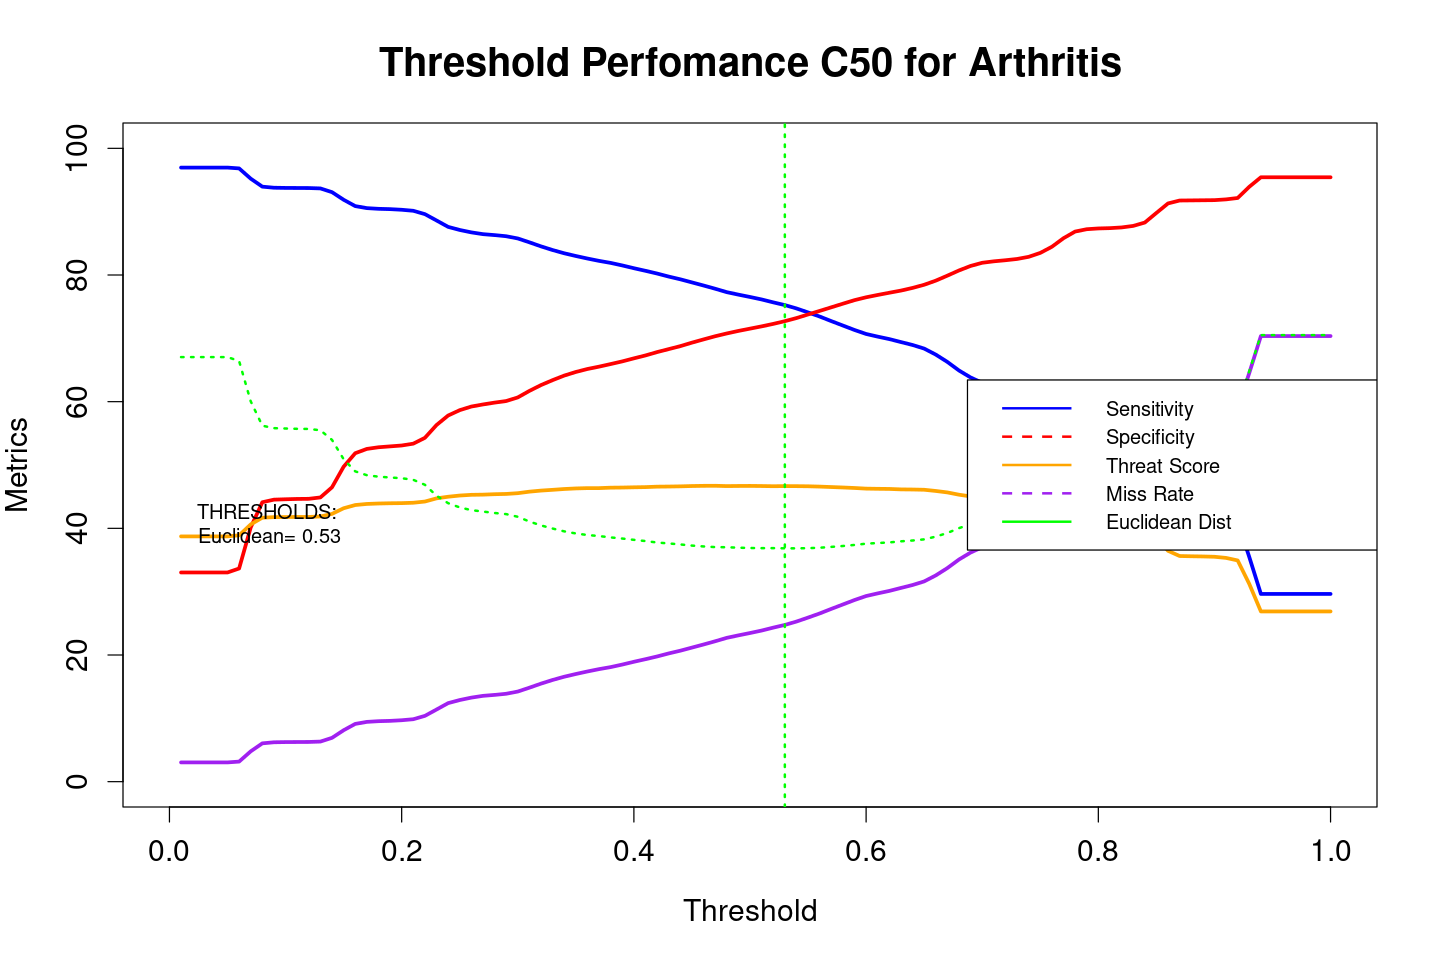

In [62]:
# options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
# Euclidean distance sqrt((1 − sensitivity)^2+ (1 − specificity)^2)
# To the top left (i.e. perfect classifier)
ARTH$distance<-sqrt(((100-ARTH$tpr)^2)+((ARTH$fpr)^2))

# Euclidean distance to "perfect" classifier (smallest the best)
# use which.min() to return a single index to the lowest value in the vector
minEuclidean<-ARTH$x[which.min(ARTH$distance)]

plot(ARTH$x,ARTH$tpr,
     xlim=c(0, 1), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Threshold",
     ylab="Metrics",
     main=paste("Threshold Perfomance C50 for Arthritis"), 
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

# Plot the specificity (100-FPR)
lines(ARTH$x,100-ARTH$fpr,type="l",col="red",lwd=3,lty=1)

# plot the threat score
lines(ARTH$x,ARTH$threatScore,type="l",col="orange",lwd=3,lty=1)

# plot the miss rate
lines(ARTH$x,ARTH$fnr,type="l",col="purple",lwd=3,lty=1)


# The point where specificity and sensitivity are the same
crosspoint<-ARTH$x[which.min(ARTH$distance)]

#     if (!is.na(crosspoint)){
#       if ((crosspoint<1) & (crosspoint>0))
#         abline(v=crosspoint,col="red",lty=3,lwd=2)
#     }

# Plot the Euclidean distance to "perfect" classifier (smallest the best)
lines(ARTH$x,ARTH$distance,type="l",col="green",lwd=2,lty=3)

# Plot the min distance, as might be more (311019NRT check it is within range)
if ((minEuclidean<1) & (minEuclidean>0))
  abline(v=minEuclidean,col="green",lty=3,lwd=2)

# Youdan (Vertical distance between the 45 degree line and the point on the ROC curve )
#lines(ARTH$x,ARTH$youdan,type="l",col="purple",lwd=2,lty=3)

#if ((maxYoudan<1) & (maxYoudan>0))
#  abline(v=maxYoudan,col="purple",lty=3,lwd=2)

legend("right",c("Sensitivity","Specificity","Threat Score","Miss Rate","Euclidean Dist"),col=c("blue","red","orange","purple", "green"),cex=1,lty=1:2,lwd=2)
text(x=0,y=50, adj = c(-0.2,2),cex=1,col="black",paste("THRESHOLDS:\nEuclidean=",minEuclidean))

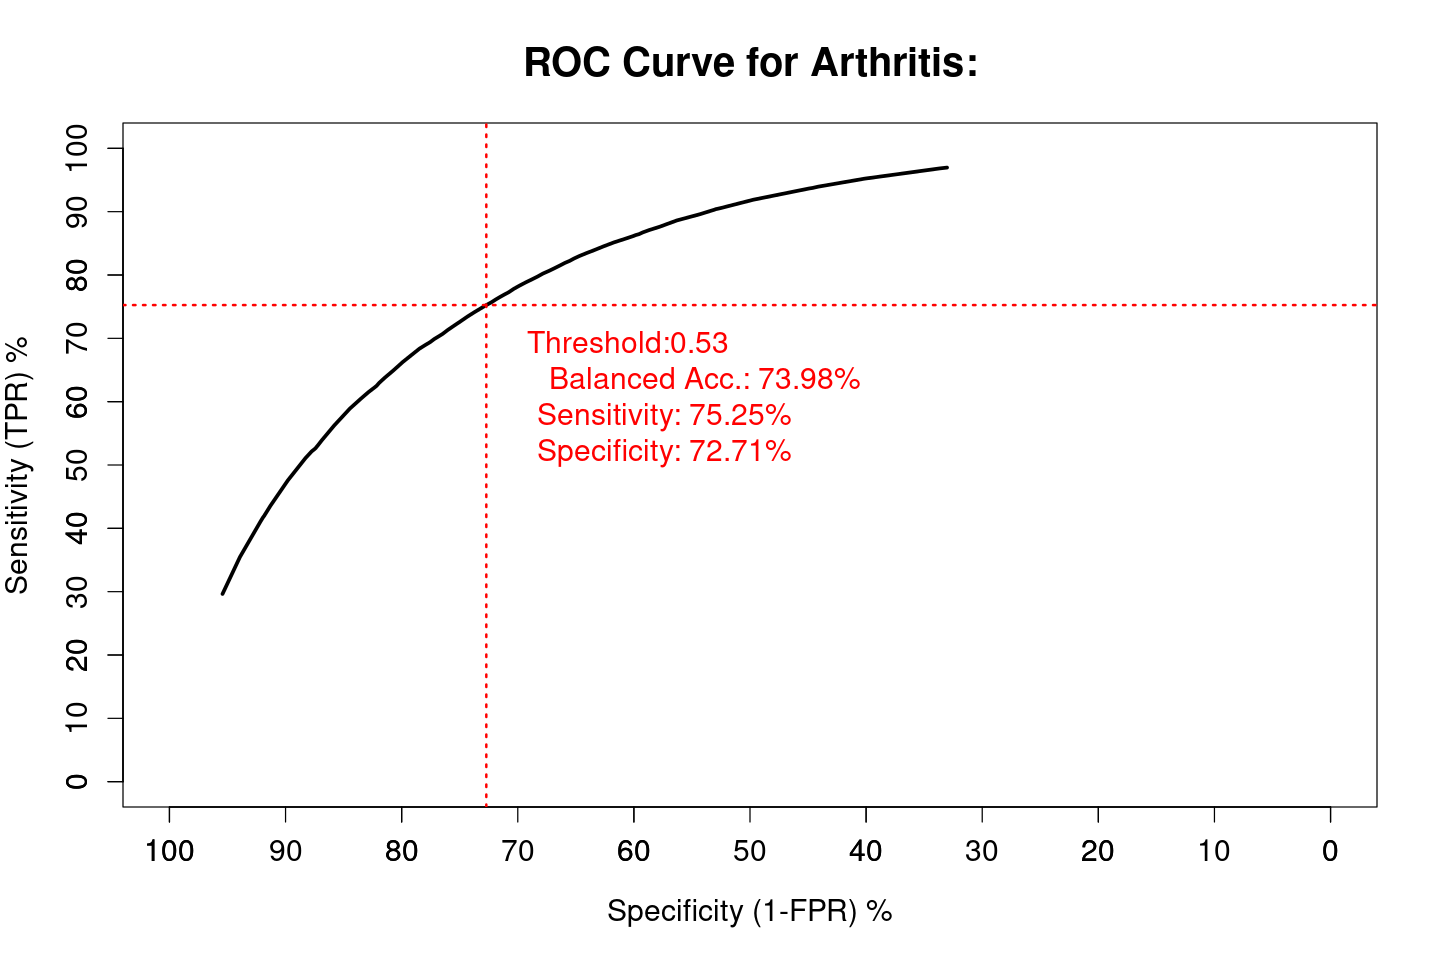

In [63]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
sensitivityROC<-ARTH$tpr[which.min(ARTH$distance)]
specificityROC<-100-ARTH$fpr[which.min(ARTH$distance)]
balacc<-ARTH$balancedacc[which.min(ARTH$distance)]


plot(100-ARTH$fpr,ARTH$tpr,type="l",lwd=3, col="black",
     main=paste("ROC Curve for Arthritis:"),
     xlab="Specificity (1-FPR) %",
     ylab="Sensitivity (TPR) %",
     xlim=c(100,0),
     ylim=c(0,100),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

axis(1, seq(0.0,100,10), cex.axis=1.5)
axis(2, seq(0.0,100,10), cex.axis=1.5)

#Add crosshairs to the graph
abline(h=sensitivityROC,col="red",lty=3,lwd=2)
abline(v=specificityROC,col="red",lty=3,lwd=2)

annotate<-paste("Threshold:",round(minEuclidean,digits=4L),
                "\nBalanced Acc.: ",round(balacc,digits=2L),
                "%\nSensitivity: ",round(sensitivityROC,digits=2L),
                "%\nSpecificity: ",round(specificityROC,digits=2L),"%",sep="")
# axis(1,cex.axis=2)
text(x=specificityROC, y=sensitivityROC, adj = c(-0.2,1.2),cex=1.5, col="red",annotate)

In [64]:
bigDatadfBalac<-rbind(bigDatadfBalac,data.frame(AccuracyBalanced=balacc,diseaseType="Arthritis"))

## CANCER

In [65]:
CANCER <- fullDT(undersampleCANCER,test,outputfield="CHCOCNCR",boost=10,plot=TRUE)

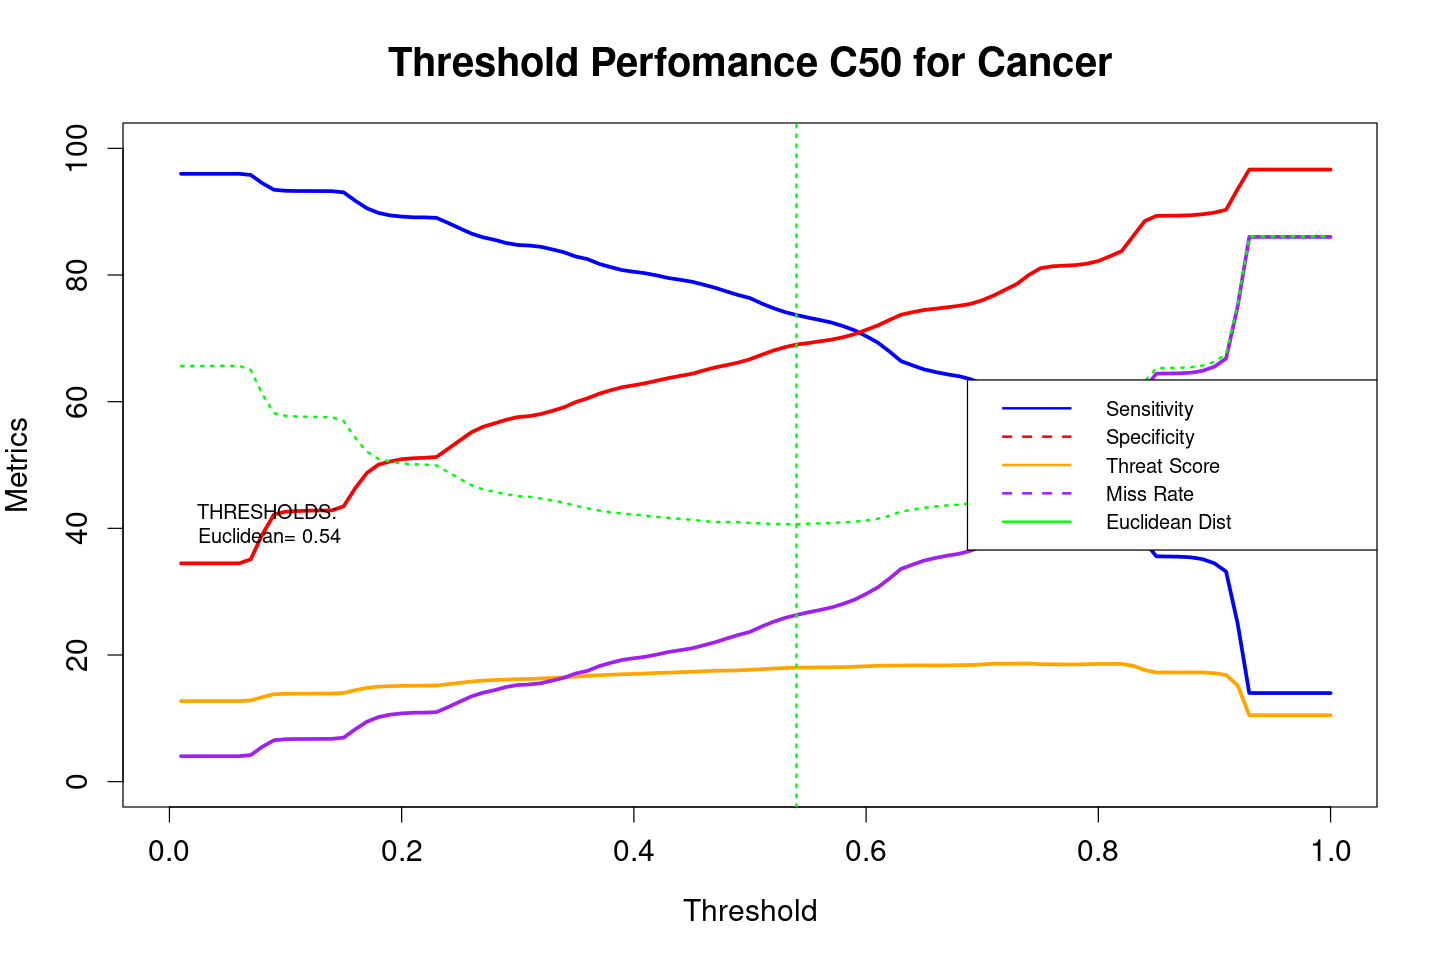

In [66]:
# options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
# Euclidean distance sqrt((1 − sensitivity)^2+ (1 − specificity)^2)
# To the top left (i.e. perfect classifier)
CANCER$distance<-sqrt(((100-CANCER$tpr)^2)+((CANCER$fpr)^2))

# Euclidean distance to "perfect" classifier (smallest the best)
# use which.min() to return a single index to the lowest value in the vector
minEuclidean<-CANCER$x[which.min(CANCER$distance)]

plot(CANCER$x,CANCER$tpr,
     xlim=c(0, 1), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Threshold",
     ylab="Metrics",
     main=paste("Threshold Perfomance C50 for Cancer"), 
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

# Plot the specificity (100-FPR)
lines(CANCER$x,100-CANCER$fpr,type="l",col="red",lwd=3,lty=1)

# plot the threat score
lines(CANCER$x,CANCER$threatScore,type="l",col="orange",lwd=3,lty=1)

# plot the miss rate
lines(CANCER$x,CANCER$fnr,type="l",col="purple",lwd=3,lty=1)


# The point where specificity and sensitivity are the same
crosspoint<-CANCER$x[which.min(CANCER$distance)]

#     if (!is.na(crosspoint)){
#       if ((crosspoint<1) & (crosspoint>0))
#         abline(v=crosspoint,col="red",lty=3,lwd=2)
#     }

# Plot the Euclidean distance to "perfect" classifier (smallest the best)
lines(CANCER$x,CANCER$distance,type="l",col="green",lwd=2,lty=3)

# Plot the min distance, as might be more (311019NRT check it is within range)
if ((minEuclidean<1) & (minEuclidean>0))
  abline(v=minEuclidean,col="green",lty=3,lwd=2)

# Youdan (Vertical distance between the 45 degree line and the point on the ROC curve )
#lines(CANCER$x,CANCER$youdan,type="l",col="purple",lwd=2,lty=3)

#if ((maxYoudan<1) & (maxYoudan>0))
#  abline(v=maxYoudan,col="purple",lty=3,lwd=2)

legend("right",c("Sensitivity","Specificity","Threat Score","Miss Rate","Euclidean Dist"),col=c("blue","red","orange","purple", "green"),cex=1,lty=1:2,lwd=2)
text(x=0,y=50, adj = c(-0.2,2),cex=1,col="black",paste("THRESHOLDS:\nEuclidean=",minEuclidean))

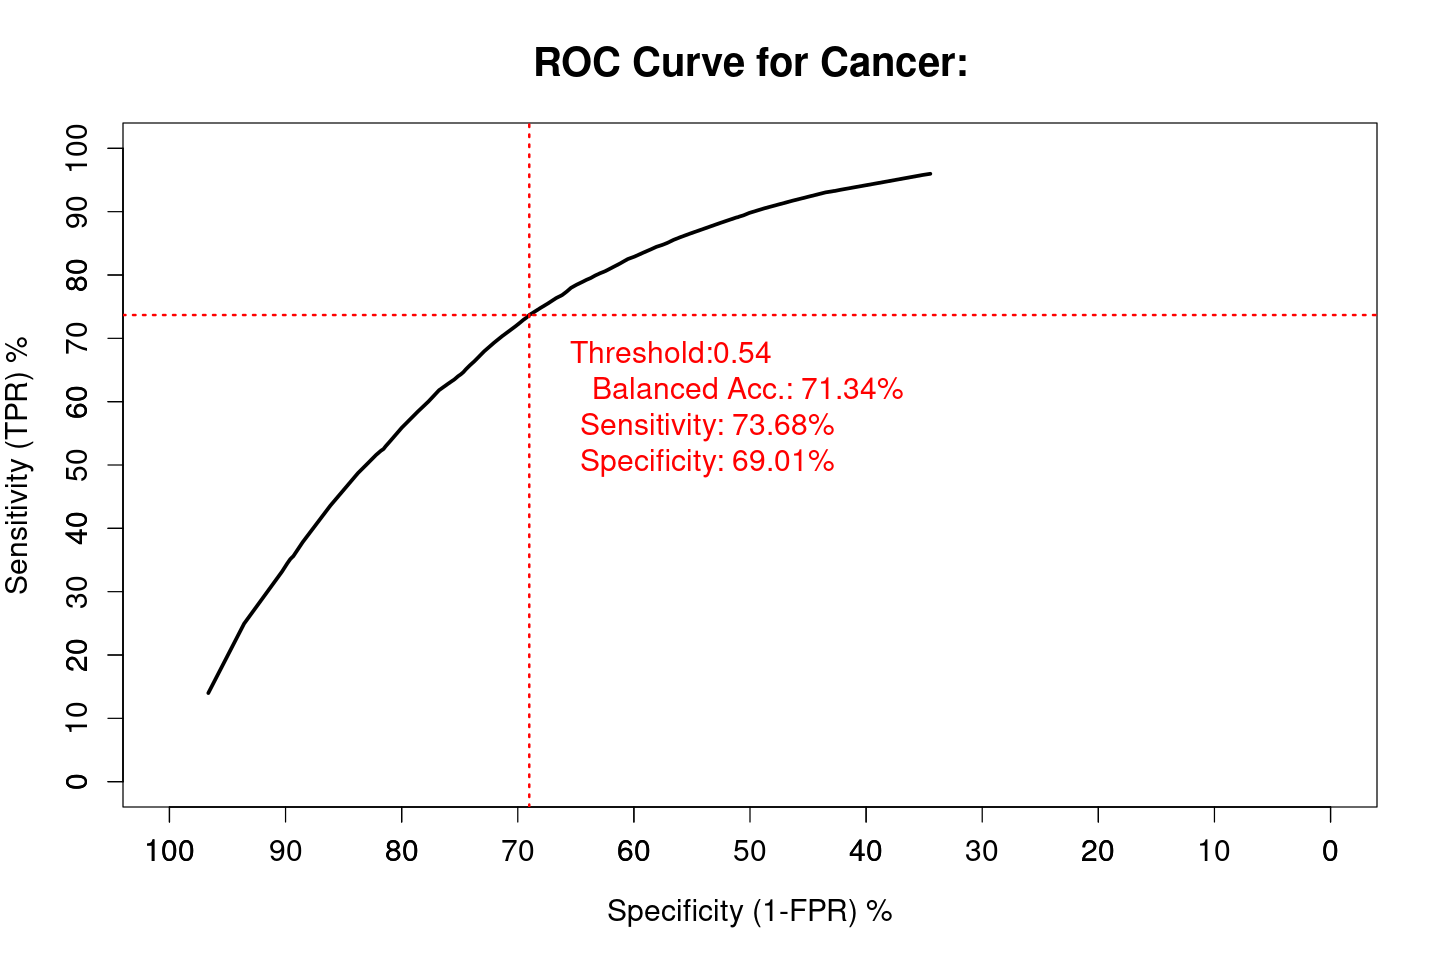

In [67]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
sensitivityROC<-CANCER$tpr[which.min(CANCER$distance)]
specificityROC<-100-CANCER$fpr[which.min(CANCER$distance)]
balacc<-CANCER$balancedacc[which.min(CANCER$distance)]


plot(100-CANCER$fpr,CANCER$tpr,type="l",lwd=3, col="black",
     main=paste("ROC Curve for Cancer:"),
     xlab="Specificity (1-FPR) %",
     ylab="Sensitivity (TPR) %",
     xlim=c(100,0),
     ylim=c(0,100),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

axis(1, seq(0.0,100,10), cex.axis=1.5)
axis(2, seq(0.0,100,10), cex.axis=1.5)

#Add crosshairs to the graph
abline(h=sensitivityROC,col="red",lty=3,lwd=2)
abline(v=specificityROC,col="red",lty=3,lwd=2)

annotate<-paste("Threshold:",round(minEuclidean,digits=4L),
                "\nBalanced Acc.: ",round(balacc,digits=2L),
                "%\nSensitivity: ",round(sensitivityROC,digits=2L),
                "%\nSpecificity: ",round(specificityROC,digits=2L),"%",sep="")
# axis(1,cex.axis=2)
text(x=specificityROC, y=sensitivityROC, adj = c(-0.2,1.2),cex=1.5, col="red",annotate)

In [68]:
bigDatadfBalac<-rbind(bigDatadfBalac,data.frame(AccuracyBalanced=balacc,diseaseType="Cancer"))

## LUNG DISEASE

In [69]:
LUNG <- fullDT(undersampleLUNG,test,outputfield="CHCCOPD2",boost=20,plot=TRUE)

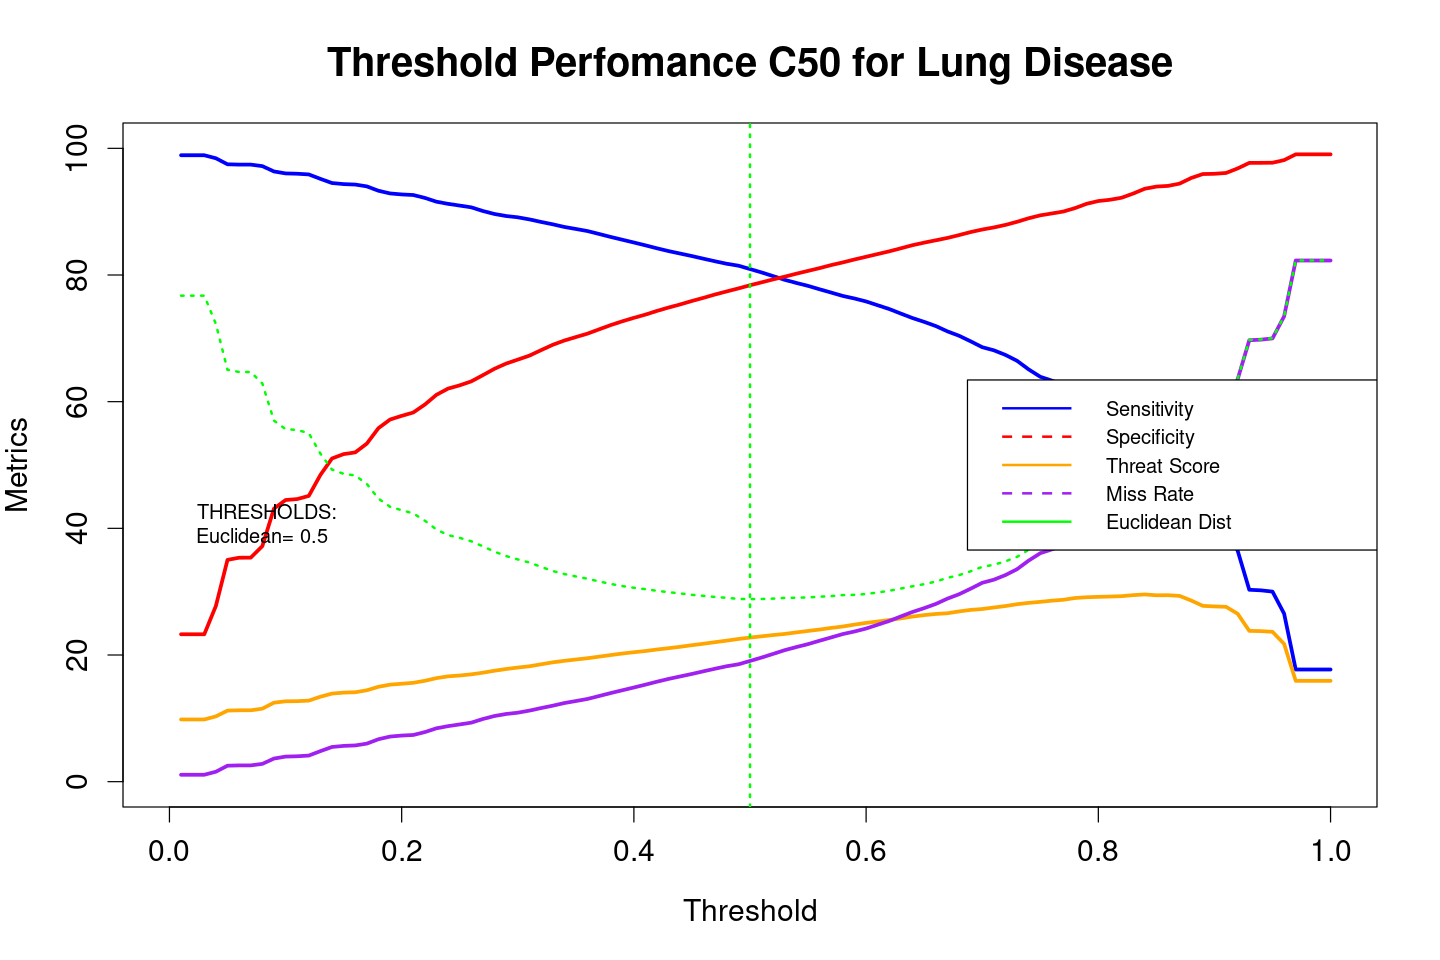

In [70]:
# options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
# Euclidean distance sqrt((1 − sensitivity)^2+ (1 − specificity)^2)
# To the top left (i.e. perfect classifier)
LUNG$distance<-sqrt(((100-LUNG$tpr)^2)+((LUNG$fpr)^2))

# Euclidean distance to "perfect" classifier (smallest the best)
# use which.min() to return a single index to the lowest value in the vector
minEuclidean<-LUNG$x[which.min(LUNG$distance)]

plot(LUNG$x,LUNG$tpr,
     xlim=c(0, 1), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Threshold",
     ylab="Metrics",
     main=paste("Threshold Perfomance C50 for Lung Disease"), 
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

# Plot the specificity (100-FPR)
lines(LUNG$x,100-LUNG$fpr,type="l",col="red",lwd=3,lty=1)

# plot the threat score
lines(LUNG$x,LUNG$threatScore,type="l",col="orange",lwd=3,lty=1)

# plot the miss rate
lines(LUNG$x,LUNG$fnr,type="l",col="purple",lwd=3,lty=1)


# The point where specificity and sensitivity are the same
crosspoint<-LUNG$x[which.min(LUNG$distance)]

#     if (!is.na(crosspoint)){
#       if ((crosspoint<1) & (crosspoint>0))
#         abline(v=crosspoint,col="red",lty=3,lwd=2)
#     }

# Plot the Euclidean distance to "perfect" classifier (smallest the best)
lines(LUNG$x,LUNG$distance,type="l",col="green",lwd=2,lty=3)

# Plot the min distance, as might be more (311019NRT check it is within range)
if ((minEuclidean<1) & (minEuclidean>0))
  abline(v=minEuclidean,col="green",lty=3,lwd=2)

# Youdan (Vertical distance between the 45 degree line and the point on the ROC curve )
#lines(LUNG$x,LUNG$youdan,type="l",col="purple",lwd=2,lty=3)

#if ((maxYoudan<1) & (maxYoudan>0))
#  abline(v=maxYoudan,col="purple",lty=3,lwd=2)

legend("right",c("Sensitivity","Specificity","Threat Score","Miss Rate","Euclidean Dist"),col=c("blue","red","orange","purple", "green"),cex=1,lty=1:2,lwd=2)
text(x=0,y=50, adj = c(-0.2,2),cex=1,col="black",paste("THRESHOLDS:\nEuclidean=",minEuclidean))

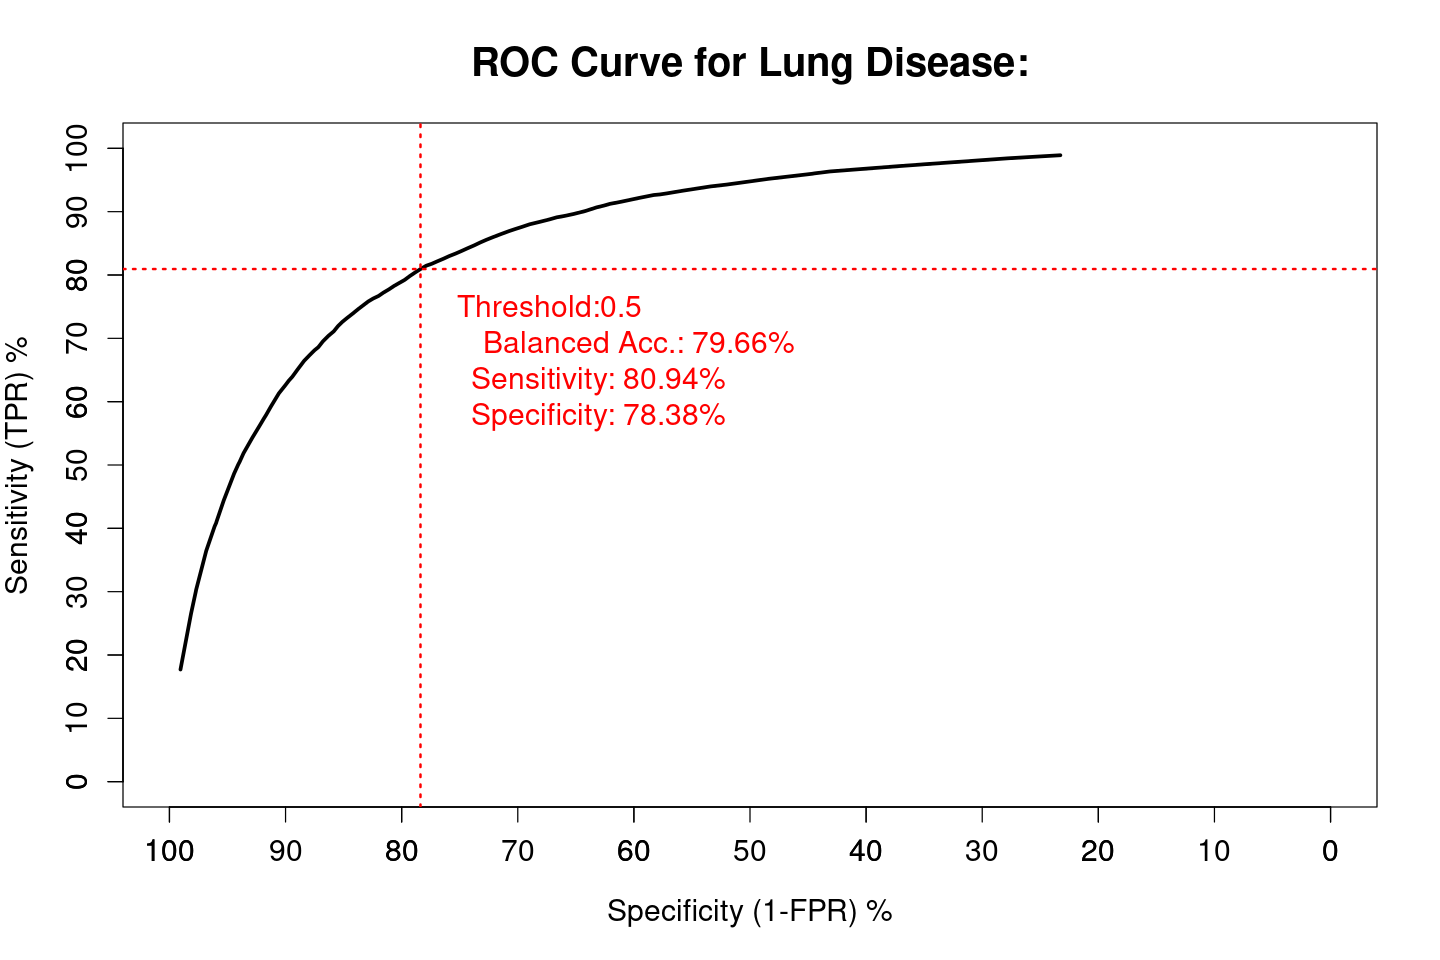

In [71]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
sensitivityROC<-LUNG$tpr[which.min(LUNG$distance)]
specificityROC<-100-LUNG$fpr[which.min(LUNG$distance)]
balacc<-LUNG$balancedacc[which.min(LUNG$distance)]


plot(100-LUNG$fpr,LUNG$tpr,type="l",lwd=3, col="black",
     main=paste("ROC Curve for Lung Disease:"),
     xlab="Specificity (1-FPR) %",
     ylab="Sensitivity (TPR) %",
     xlim=c(100,0),
     ylim=c(0,100),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

axis(1, seq(0.0,100,10), cex.axis=1.5)
axis(2, seq(0.0,100,10), cex.axis=1.5)

#Add crosshairs to the graph
abline(h=sensitivityROC,col="red",lty=3,lwd=2)
abline(v=specificityROC,col="red",lty=3,lwd=2)

annotate<-paste("Threshold:",round(minEuclidean,digits=4L),
                "\nBalanced Acc.: ",round(balacc,digits=2L),
                "%\nSensitivity: ",round(sensitivityROC,digits=2L),
                "%\nSpecificity: ",round(specificityROC,digits=2L),"%",sep="")
# axis(1,cex.axis=2)
text(x=specificityROC, y=sensitivityROC, adj = c(-0.2,1.2),cex=1.5, col="red",annotate)

In [72]:
bigDatadfBalac<-rbind(bigDatadfBalac,data.frame(AccuracyBalanced=balacc,diseaseType="Lung Disease"))

## DIABETES

In [73]:
DIAB <- fullDT(undersampleDIAB,test,outputfield="DIABETE4",boost=19,plot=TRUE)

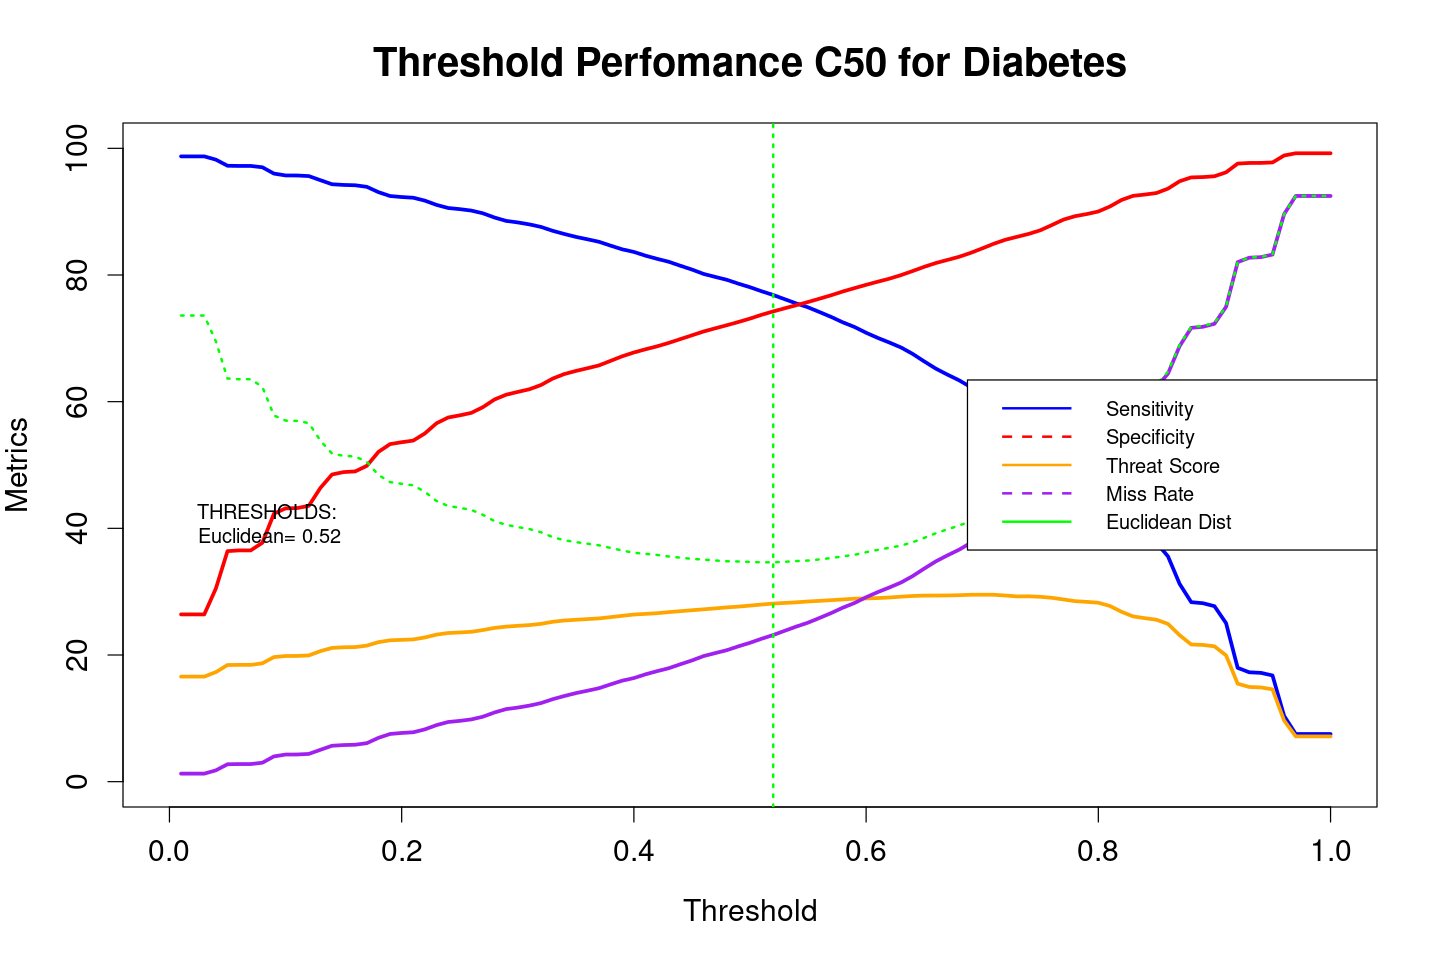

In [74]:
# options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
# Euclidean distance sqrt((1 − sensitivity)^2+ (1 − specificity)^2)
# To the top left (i.e. perfect classifier)
DIAB$distance<-sqrt(((100-DIAB$tpr)^2)+((DIAB$fpr)^2))

# Euclidean distance to "perfect" classifier (smallest the best)
# use which.min() to return a single index to the lowest value in the vector
minEuclidean<-DIAB$x[which.min(DIAB$distance)]

plot(DIAB$x,DIAB$tpr,
     xlim=c(0, 1), ylim=c(0, 100),
     type="l",lwd=3, col="blue",
     xlab="Threshold",
     ylab="Metrics",
     main=paste("Threshold Perfomance C50 for Diabetes"), 
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

# Plot the specificity (100-FPR)
lines(DIAB$x,100-DIAB$fpr,type="l",col="red",lwd=3,lty=1)

# plot the threat score
lines(DIAB$x,DIAB$threatScore,type="l",col="orange",lwd=3,lty=1)

# plot the miss rate
lines(DIAB$x,DIAB$fnr,type="l",col="purple",lwd=3,lty=1)


# The point where specificity and sensitivity are the same
crosspoint<-DIAB$x[which.min(DIAB$distance)]

#     if (!is.na(crosspoint)){
#       if ((crosspoint<1) & (crosspoint>0))
#         abline(v=crosspoint,col="red",lty=3,lwd=2)
#     }

# Plot the Euclidean distance to "perfect" classifier (smallest the best)
lines(DIAB$x,DIAB$distance,type="l",col="green",lwd=2,lty=3)

# Plot the min distance, as might be more (311019NRT check it is within range)
if ((minEuclidean<1) & (minEuclidean>0))
  abline(v=minEuclidean,col="green",lty=3,lwd=2)

# Youdan (Vertical distance between the 45 degree line and the point on the ROC curve )
#lines(DIAB$x,DIAB$youdan,type="l",col="purple",lwd=2,lty=3)

#if ((maxYoudan<1) & (maxYoudan>0))
#  abline(v=maxYoudan,col="purple",lty=3,lwd=2)

legend("right",c("Sensitivity","Specificity","Threat Score","Miss Rate","Euclidean Dist"),col=c("blue","red","orange","purple", "green"),cex=1,lty=1:2,lwd=2)
text(x=0,y=50, adj = c(-0.2,2),cex=1,col="black",paste("THRESHOLDS:\nEuclidean=",minEuclidean))

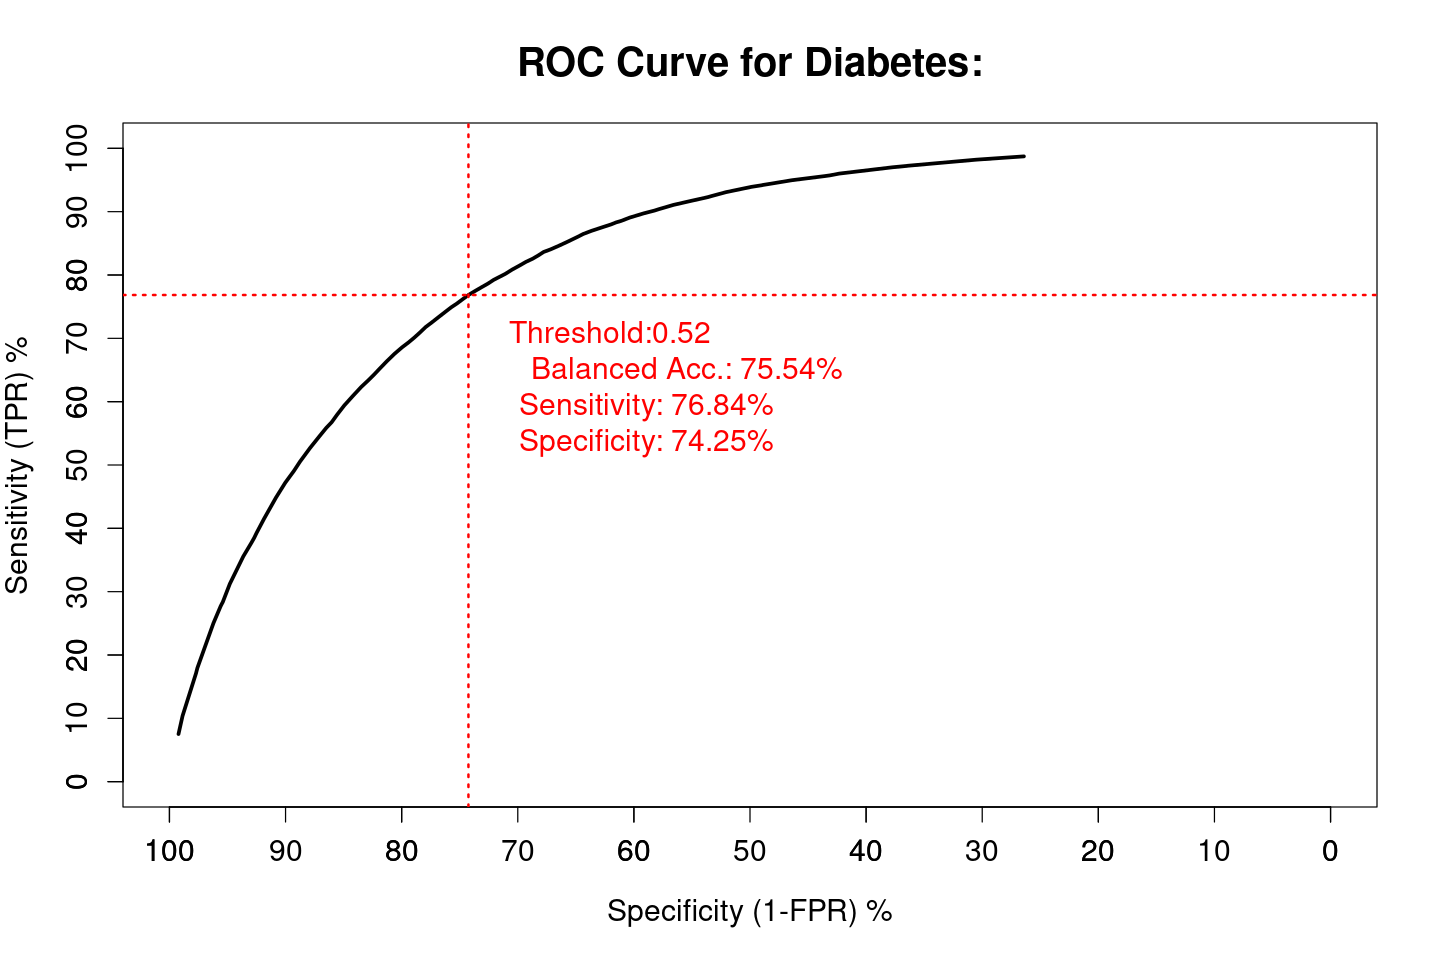

In [75]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=15)
sensitivityROC<-DIAB$tpr[which.min(DIAB$distance)] # calculates the sensitivity for the ideal threshold
specificityROC<-100-DIAB$fpr[which.min(DIAB$distance)] # calculates the specificity for the ideal threshold
balacc<-DIAB$balancedacc[which.min(DIAB$distance)] # calculates the balanced accuracy for the ideal threshold


plot(100-DIAB$fpr,DIAB$tpr,type="l",lwd=3, col="black",
     main=paste("ROC Curve for Diabetes:"),
     xlab="Specificity (1-FPR) %",
     ylab="Sensitivity (TPR) %",
     xlim=c(100,0),
     ylim=c(0,100),
     cex.lab = 1.5,
     cex.axis=1.5,
     cex.main = 2
)

axis(1, seq(0.0,100,10), cex.axis=1.5)
axis(2, seq(0.0,100,10), cex.axis=1.5)

#Add crosshairs to the graph
abline(h=sensitivityROC,col="red",lty=3,lwd=2)
abline(v=specificityROC,col="red",lty=3,lwd=2)

annotate<-paste("Threshold:",round(minEuclidean,digits=4L),
                "\nBalanced Acc.: ",round(balacc,digits=2L),
                "%\nSensitivity: ",round(sensitivityROC,digits=2L),
                "%\nSpecificity: ",round(specificityROC,digits=2L),"%",sep="")
# axis(1,cex.axis=2)
text(x=specificityROC, y=sensitivityROC, adj = c(-0.2,1.2),cex=1.5, col="red",annotate)

In [76]:
bigDatadfBalac<-rbind(bigDatadfBalac,data.frame(AccuracyBalanced=balacc,diseaseType="Diabetes"))

In [77]:
bigDatadfBalac

AccuracyBalanced,diseaseType
<dbl>,<chr>
65.90,Asthma
80.28,Heart Disease
73.62,Skin Disease
74.67,Kidney Disease
73.98,Arthritis
71.34,Cancer
79.66,Lung Disease
75.54,Diabetes


# $\color{blue}{\text{Measuring the importances using C5imp:}}$

In [78]:
# Function was taken but modified from lab 4 to produce a dataframe if descending importances for C5.0 for each disease
impfullDT<-function(train,test,outputfield="",boost=1,plot=TRUE){

    positionClassOutput<-which(names(train)==outputfield)

    # train data: dataframe with the input fields
    train_inputs<-train[-positionClassOutput]

    # train data: vector with the expedcted output
    train_expected<-train[,positionClassOutput]

    # ************************************************
    # Create a standard Decision Tree using the C5.0 algorithm
    # Uses library C50
    # Outputs the tree in the format of rules


    tree<-C50::C5.0(x=train_inputs,
                  factor(train_expected),
                  rules=TRUE,
                  trials=boost)

    # Get importance of the input fields
    importance<-C50::C5imp(tree, metric = "usage")
    names(importance)<-"Strength"

    importance<-importance[order(importance$Strength,decreasing=TRUE),,drop=FALSE]

  return(importance)
} #endof fullDT()


In [79]:
ASTH <- impfullDT(undersampleASTH,test,outputfield="ASTHMA3",boost=10,plot=TRUE)

In [80]:
ASTHf5<-head(ASTH,5)

In [81]:
ASTHf5

,Strength
,<dbl>
CHCCOPD2,100.00
AGEG5YR,97.62
GENHLTH,91.42
BMI5,86.71
ADDEPEV3,82.03


In [82]:
# install.packages("RColorBrewer")
library(RColorBrewer)
p <- brewer.pal(n = 5, name = "YlOrRd")

In [83]:
p<-rev(p)

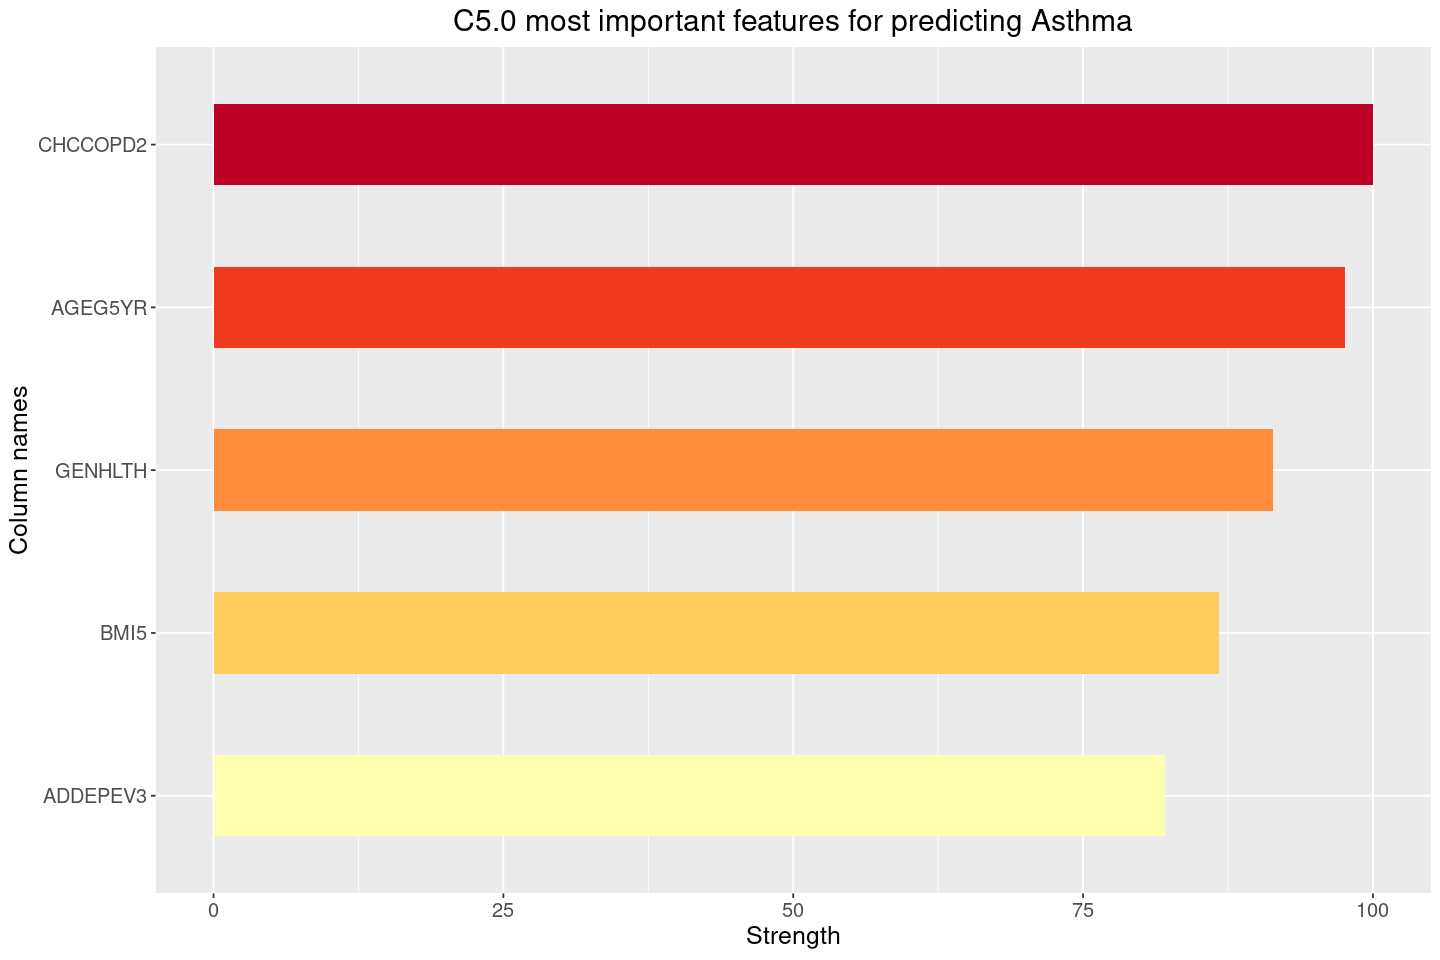

In [84]:
ASTHf5plot <- ggplot(ASTHf5, aes(x=ASTHf5[,], y=reorder(rownames(ASTHf5), ASTHf5[,])))+ geom_bar(stat="identity", fill = p, width =0.5) + labs(x="Strength", y="Column names")+ theme(text = element_text(size = 15))+ ggtitle("C5.0 most important features for predicting Asthma")+ theme(plot.title = element_text(hjust = 0.5))#+xlim(75,110)
ASTHf5plot

In [85]:
HEART <- impfullDT(undersampleHEART,test,outputfield="CVDCRHD4",boost=17,plot=TRUE)
HEARTf5<-head(HEART,5)

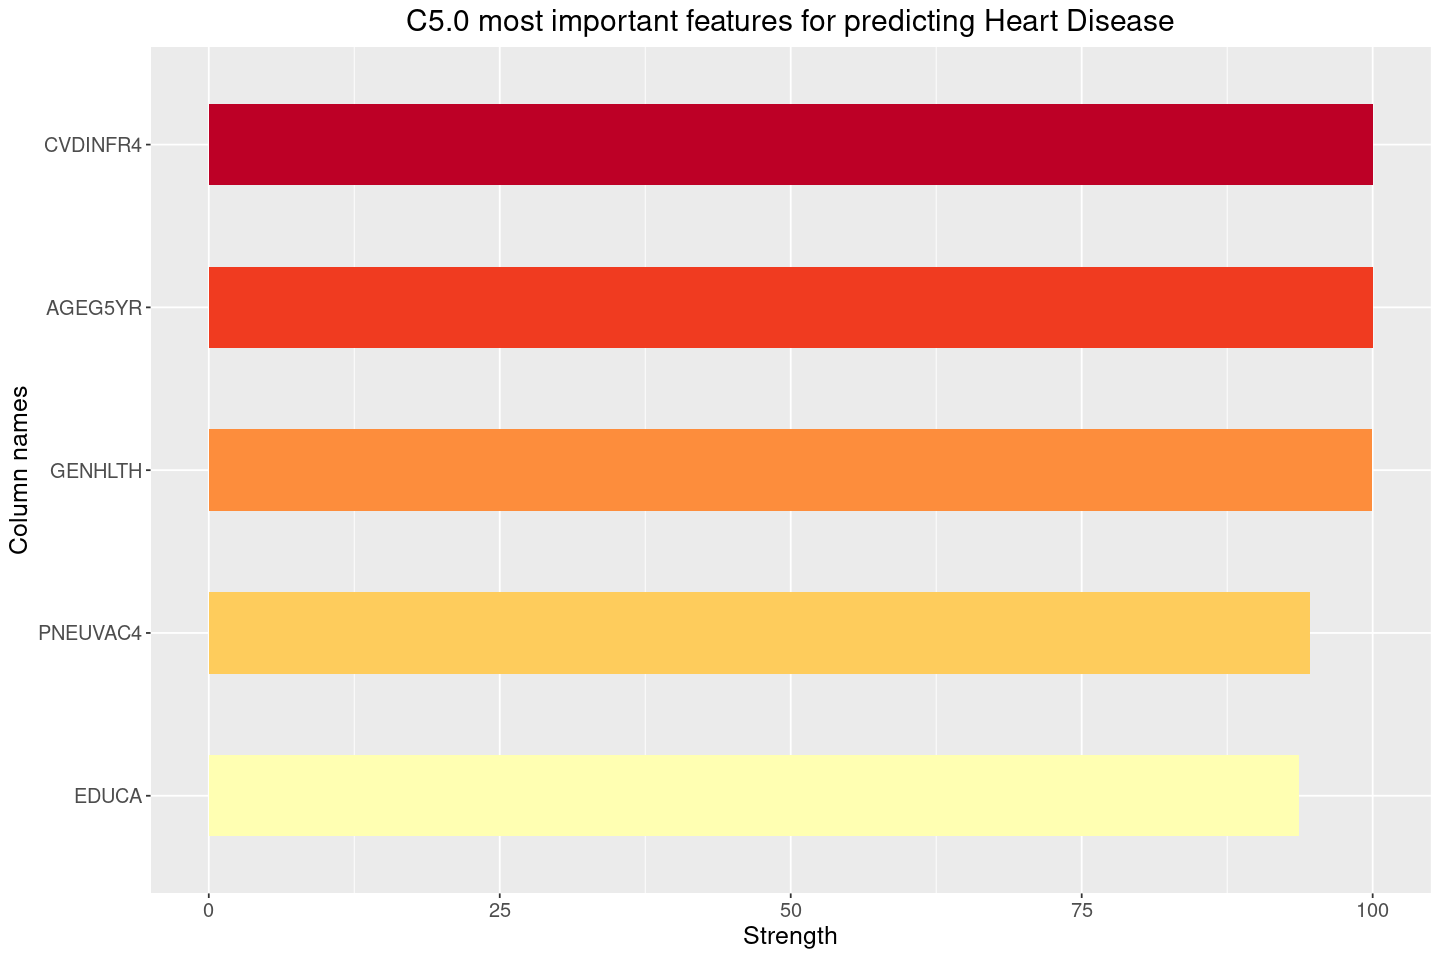

In [86]:
HEARTf5plot <- ggplot(HEARTf5, aes(x=HEARTf5[,], y=reorder(rownames(HEARTf5), HEARTf5[,])))+ geom_bar(stat="identity", fill = p, width =0.5) + labs(x="Strength", y="Column names")+ theme(text = element_text(size = 15))+ ggtitle("C5.0 most important features for predicting Heart Disease")+ theme(plot.title = element_text(hjust = 0.5))
HEARTf5plot

In [87]:
SKIN <- impfullDT(undersampleSKIN,test,outputfield="CHCSCNCR",boost=12,plot=TRUE)
SKINf5<-head(SKIN,5)

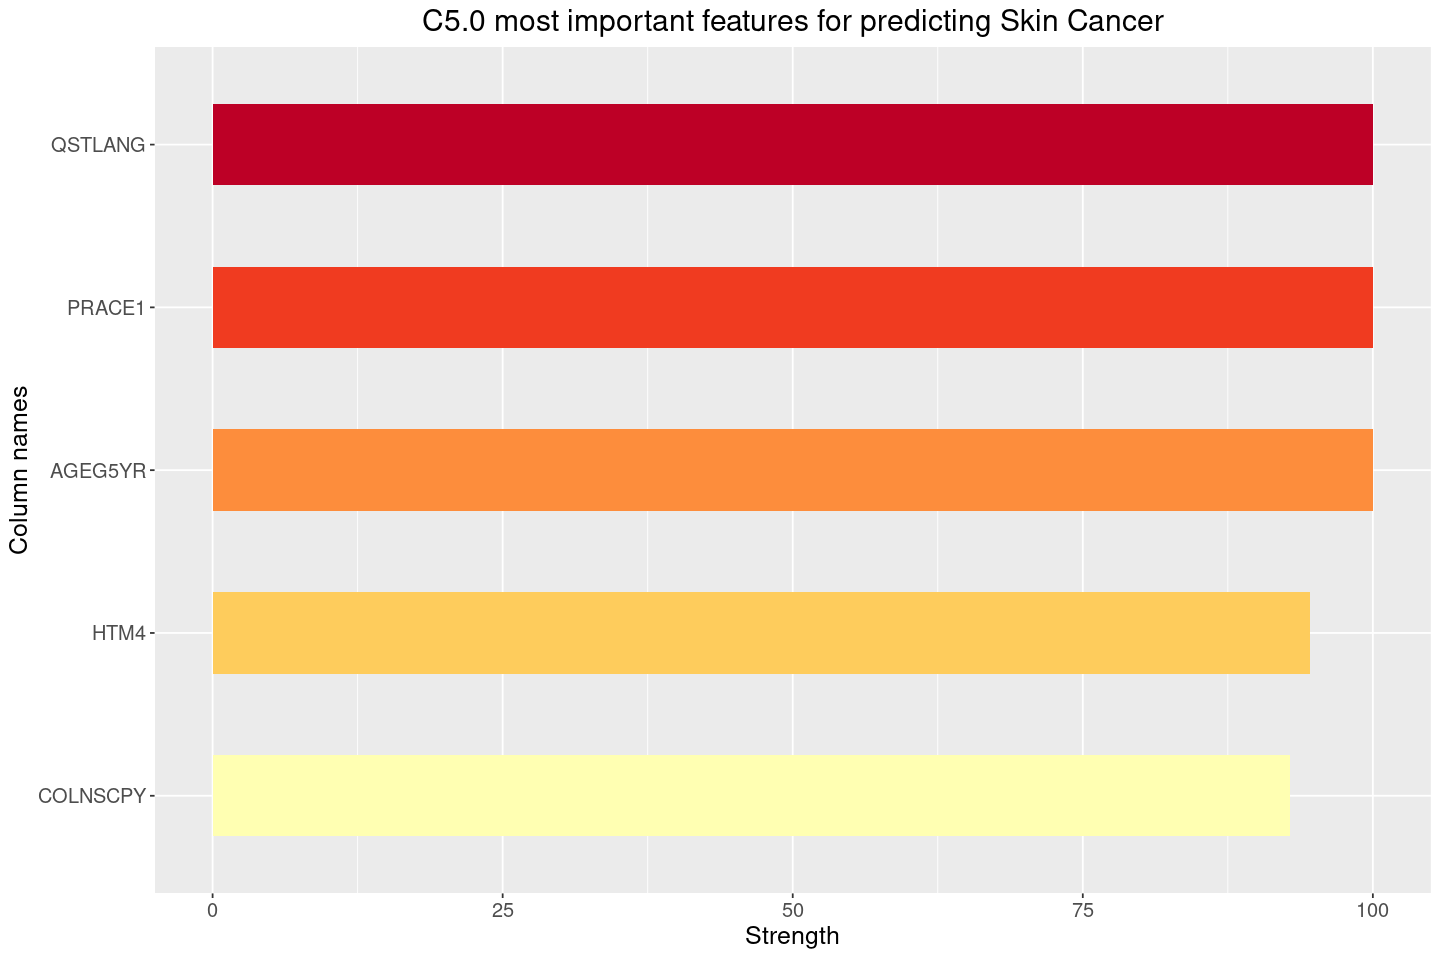

In [88]:
SKINf5plot <- ggplot(SKINf5,  aes(x=SKINf5[,], y=reorder(rownames(SKINf5), SKINf5[,])))+ geom_bar(stat="identity", fill = p, width =0.5) + labs(x="Strength", y="Column names")+ theme(text = element_text(size = 15))+ ggtitle("C5.0 most important features for predicting Skin Cancer")+ theme(plot.title = element_text(hjust = 0.5))#+xlim(75,110) 
SKINf5plot

In [89]:
KIDNEY <- impfullDT(undersampleKIDNEY,test,outputfield="CHCKDNY2",boost=13,plot=TRUE)
KIDNEYf5<-head(KIDNEY,5)

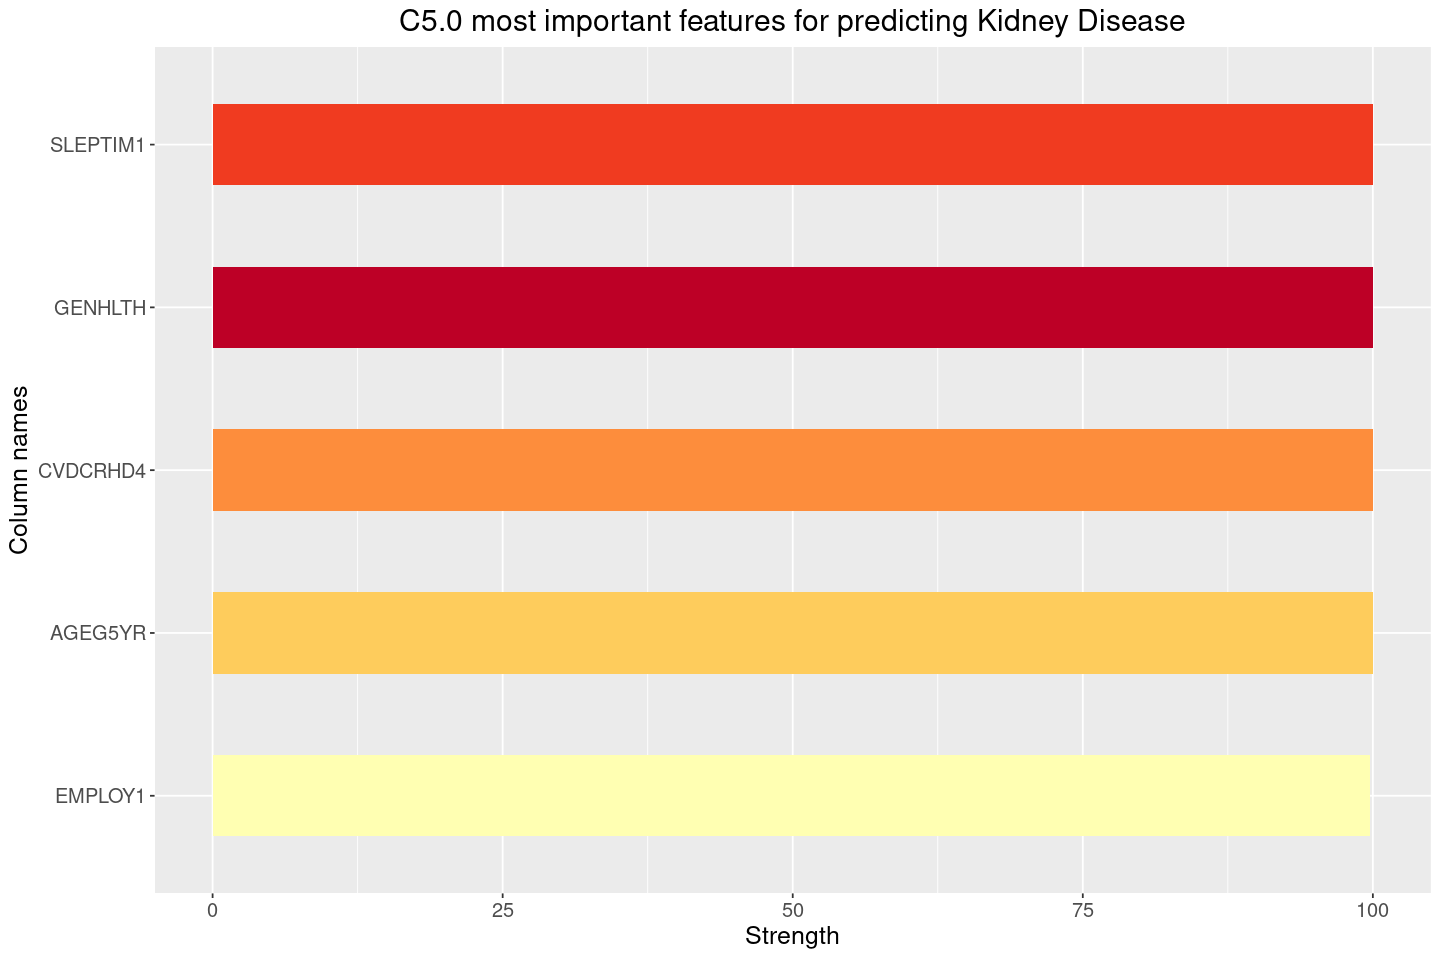

In [90]:
KIDNEYf5plot <- ggplot(KIDNEYf5, aes(x=KIDNEYf5[,], y=reorder(rownames(KIDNEYf5), KIDNEYf5[,])))+ geom_bar(stat="identity", fill = p, width =0.5) + labs(x="Strength", y="Column names")+ theme(text = element_text(size = 15))+ ggtitle("C5.0 most important features for predicting Kidney Disease")+ theme(plot.title = element_text(hjust = 0.5))#+xlim(75,110)
KIDNEYf5plot

In [91]:
ARTH <- impfullDT(undersampleARTH,test,outputfield="HAVARTH4",boost=11,plot=TRUE)
ARTHf5<-head(ARTH,5)

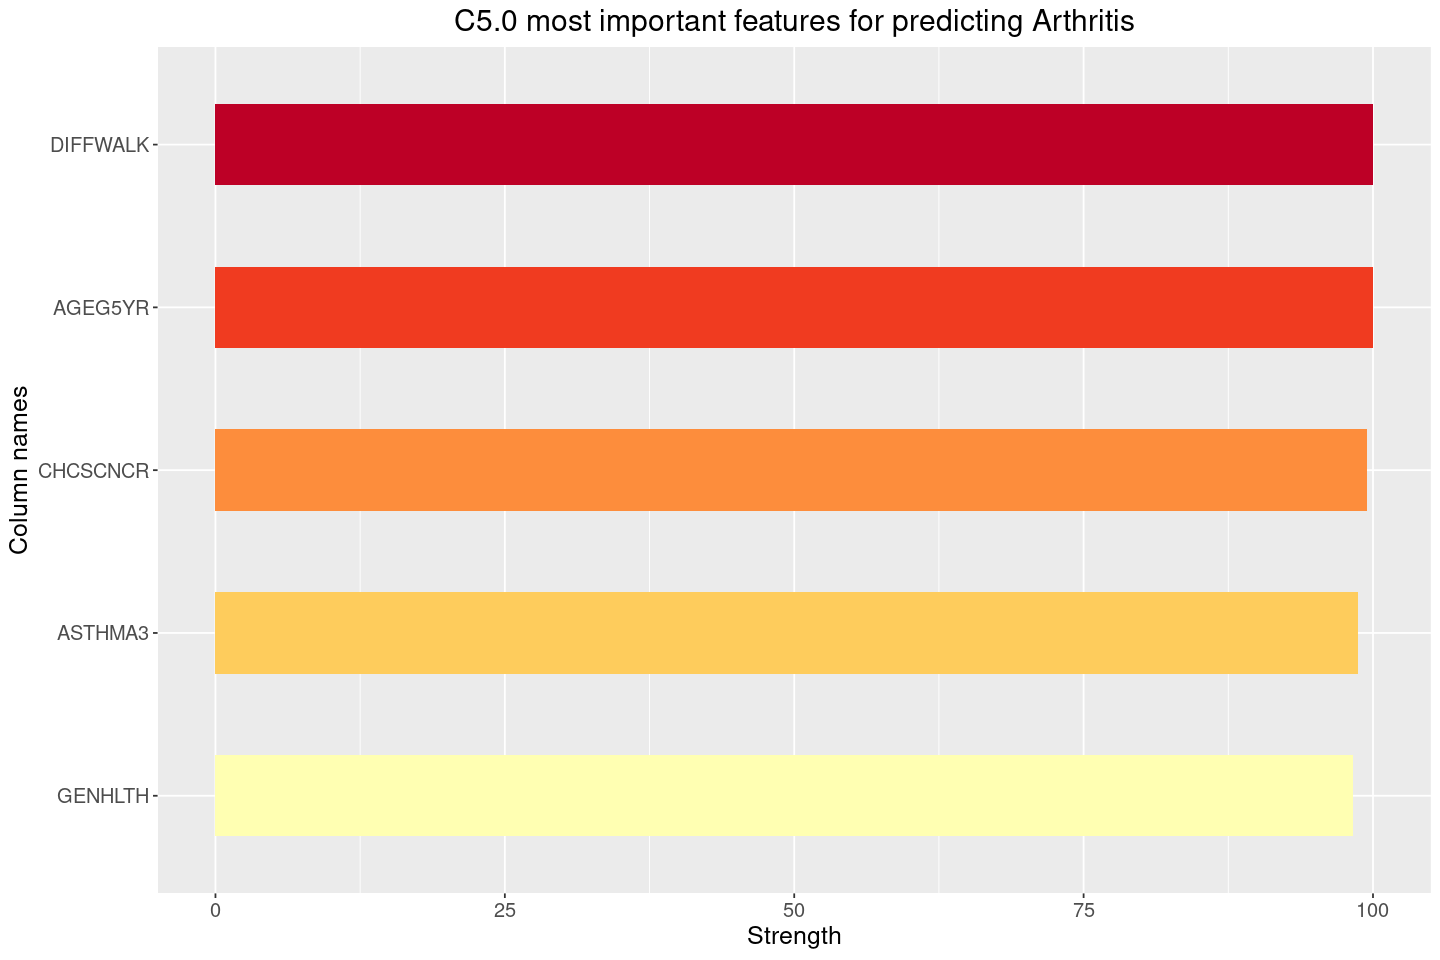

In [92]:
ARTHf5plot <- ggplot(ARTHf5, aes(x=ARTHf5[,], y=reorder(rownames(ARTHf5), ARTHf5[,])))+ geom_bar(stat="identity", fill = p, width =0.5) + labs(x="Strength", y="Column names")+ theme(text = element_text(size = 15))+ ggtitle("C5.0 most important features for predicting Arthritis")+ theme(plot.title = element_text(hjust = 0.5))#+xlim(75,110)
ARTHf5plot

In [93]:
CANCER <- impfullDT(undersampleCANCER,test,outputfield="CHCOCNCR",boost=10,plot=TRUE)
CANCERf5<-head(CANCER,5)

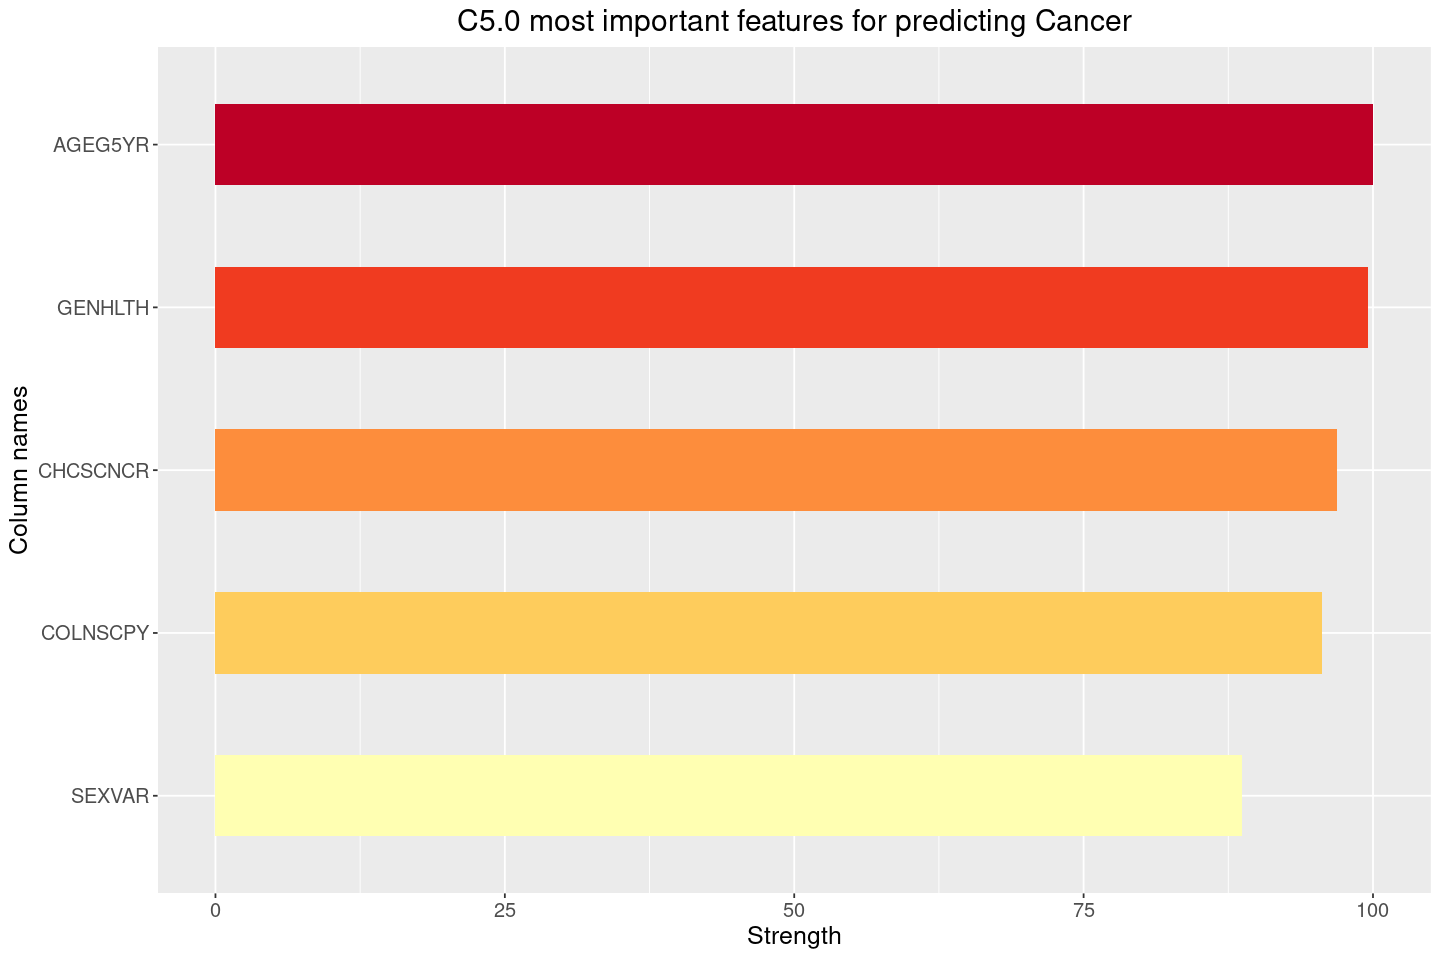

In [94]:
CANCERf5plot <- ggplot(CANCERf5, aes(x=CANCERf5[,], y=reorder(rownames(CANCERf5), CANCERf5[,])))+ geom_bar(stat="identity", fill = p, width =0.5) + labs(x="Strength", y="Column names")+ theme(text = element_text(size = 15))+ ggtitle("C5.0 most important features for predicting Cancer")+ theme(plot.title = element_text(hjust = 0.5))#+xlim(75,110)
CANCERf5plot

In [95]:
LUNG <- impfullDT(undersampleLUNG,test,outputfield="CHCCOPD2",boost=20,plot=TRUE)
LUNGf5<-head(LUNG,5)

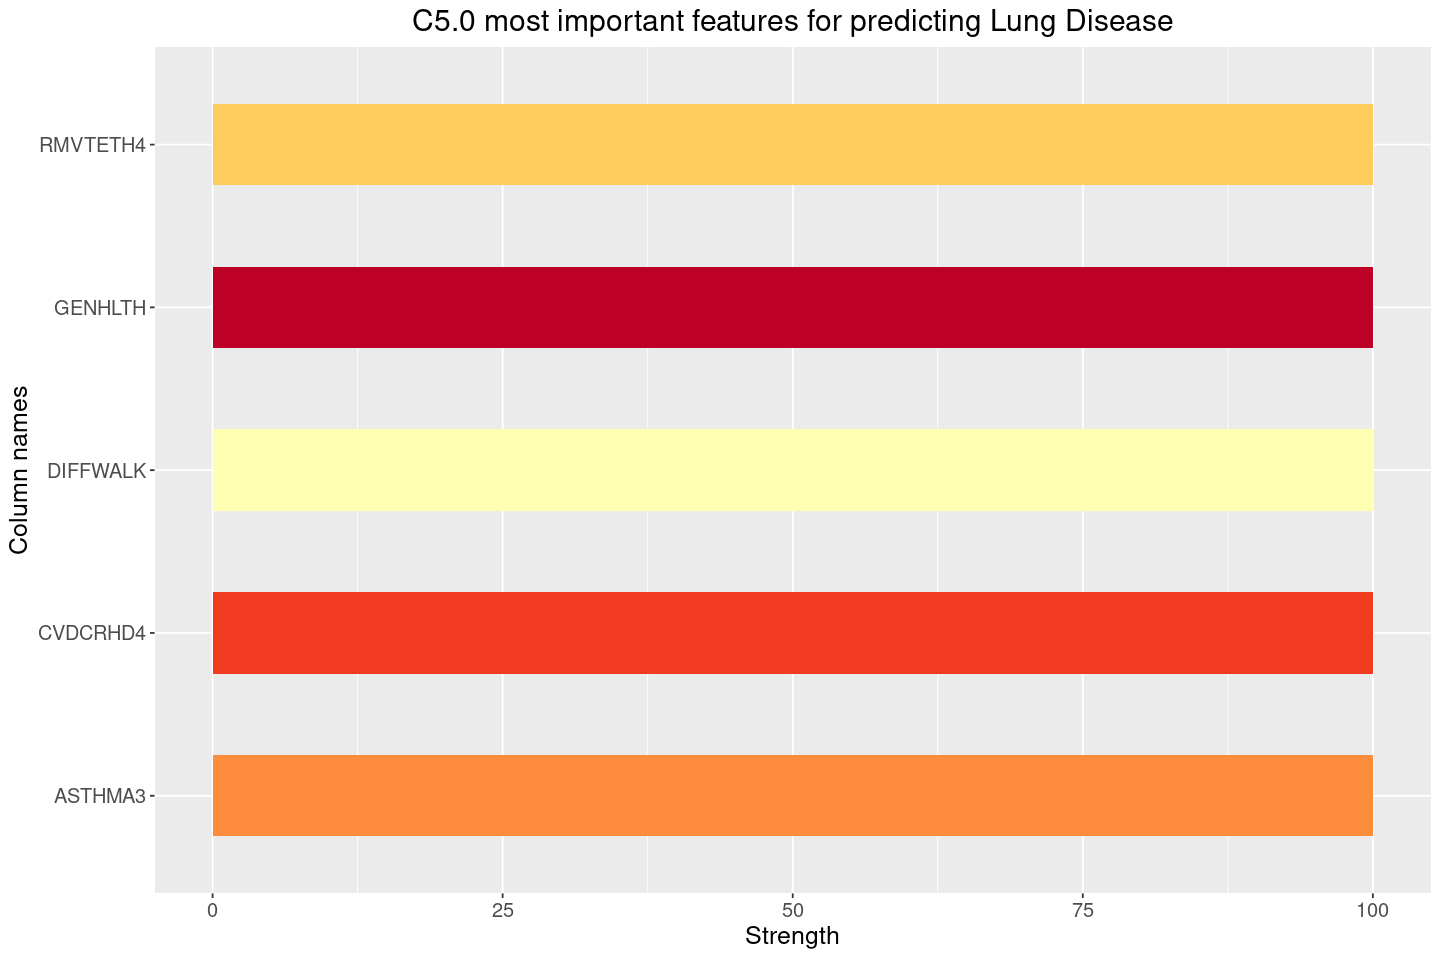

In [96]:
LUNGf5plot <- ggplot(LUNGf5, aes(x=LUNGf5[,], y=reorder(rownames(LUNGf5), LUNGf5[,])))+ geom_bar(stat="identity", fill = p, width =0.5) + labs(x="Strength", y="Column names")+ theme(text = element_text(size = 15))+ ggtitle("C5.0 most important features for predicting Lung Disease")+ theme(plot.title = element_text(hjust = 0.5))#+xlim(75,110)
LUNGf5plot

In [97]:
DIAB <- impfullDT(undersampleDIAB,test,outputfield="DIABETE4",boost=19,plot=TRUE)
DIABf5<-head(DIAB,5)

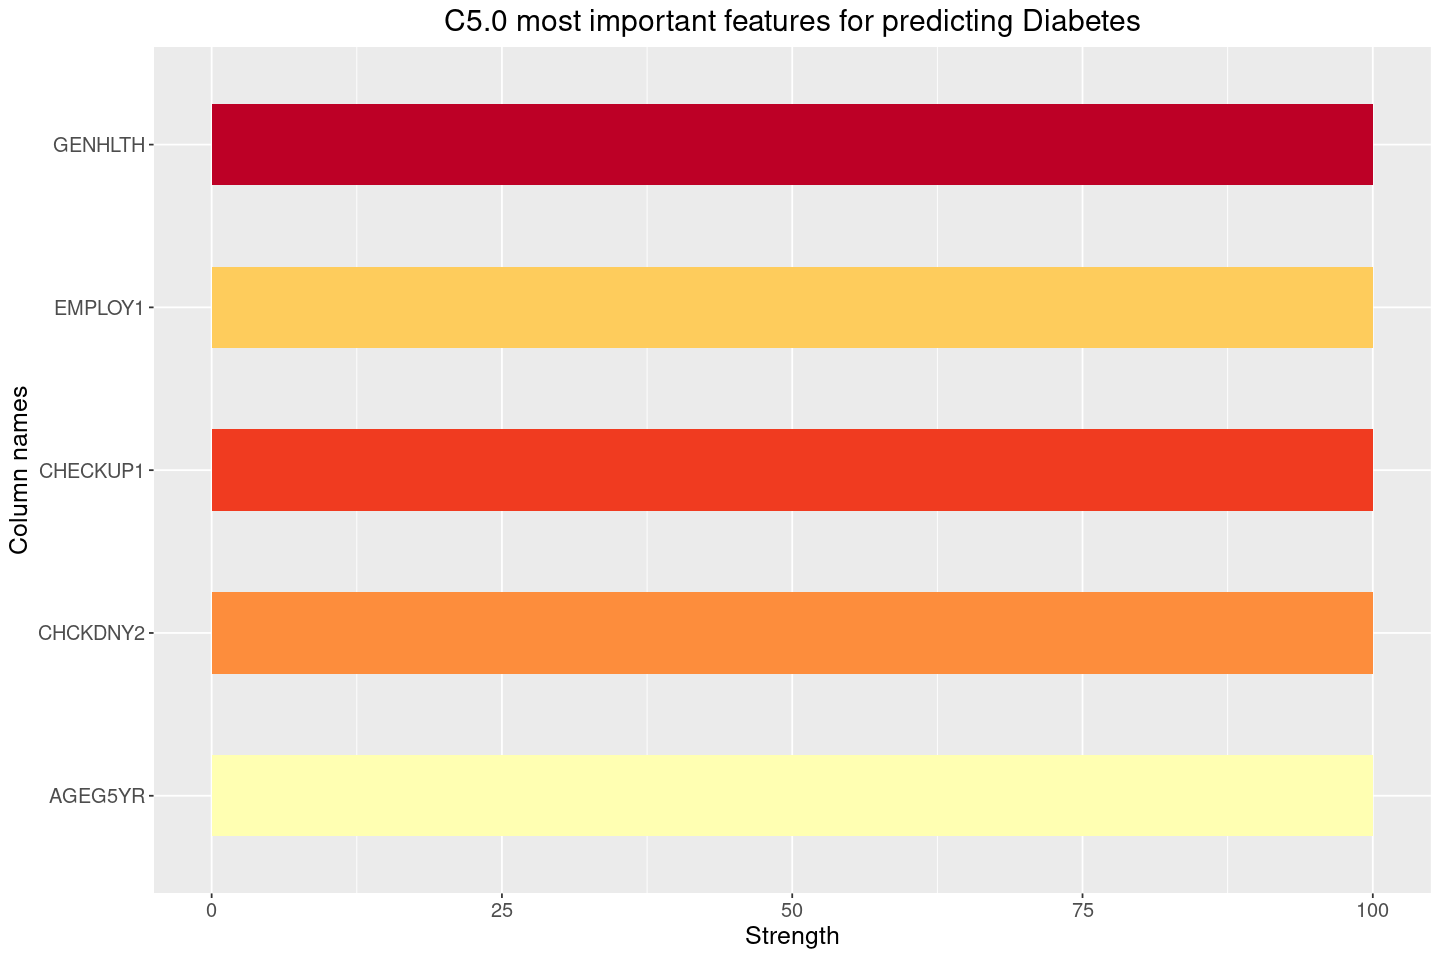

In [98]:
DIABf5plot <- ggplot(DIABf5, aes(x=DIABf5[,], y=reorder(rownames(DIABf5), DIABf5[,])))+ geom_bar(stat="identity", fill = p, width =0.5) + labs(x="Strength", y="Column names")+ theme(text = element_text(size = 15))+ ggtitle("C5.0 most important features for predicting Diabetes")+ theme(plot.title = element_text(hjust = 0.5))#+xlim(75,110)
DIABf5plot

In [99]:
# ASTH <- fullDT(undersampleASTH,test,outputfield="ASTHMA3",boost=20,plot=TRUE)

# HEART <- fullDT(undersampleHEART,test,outputfield="CVDCRHD4",boost=20,plot=TRUE)

# SKIN <- fullDT(undersampleSKIN,test,outputfield="CHCSCNCR",boost=20,plot=TRUE)

# KIDNEY <- fullDT(undersampleKIDNEY,test,outputfield="CHCKDNY2",boost=20,plot=TRUE)

# ARTH <- fullDT(undersampleARTH,test,outputfield="HAVARTH4",boost=20,plot=TRUE)

# CANCER <- fullDT(undersampleCANCER,test,outputfield="CHCOCNCR",boost=20,plot=TRUE)

# LUNG <- fullDT(undersampleLUNG,test,outputfield="CHCCOPD2",boost=20,plot=TRUE)

# DIAB <- fullDT(undersampleDIAB,test,outputfield="DIABETE4",boost=20,plot=TRUE)